- var multiatt 4block 0 0 4 1
    * pretrained VGG:  2.095, 0.696 | 1.8864837881913588, 0.7127333519086096
    * pretrained VGG without alpha: very low accuracy (0.64 in val set)
    * pretrained VGG single alpha: 0.6985232655335748 | 2.1038190721687036, 0.7132906101978267
    
- squeeze and excitation without var
    * pretrianed VGG with single lambda: 0.6985232655335748 | 1.891052357005634, 0.7227640011145166
    * from scratch VGG 3 block 2 att: 0.6826414042908888 | 1.881658147523316, 0.6915575369183616
    * from sctach VGG 3 block 2 att (replace size by instance sampling): 0.685427695736974 | 1.8196784177341976, 0.6946224575090555
    * * from sctach VGG 3 block 3 att (replace size by instance sampling): 0.6851490665923655 | 1.9143673290811762, 0.6918361660629702

- SE + MultiAtt
    * pretrained VGG with single lambda: 0.7010309278350515 | 2.189959612567755, 0.7057676232933965

- var multiatt 4 block 4 4 4 1
    * pretrained VGG: 2.1691, 0.6999 | 2.0086911175120803, 0.7093898021733074
    


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

## Dataset

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [14]:
batch_size= 64

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
images, labels = iter(train_loader).next()
images.size(), labels.size()


(torch.Size([64, 1, 64, 64]), torch.Size([64]))

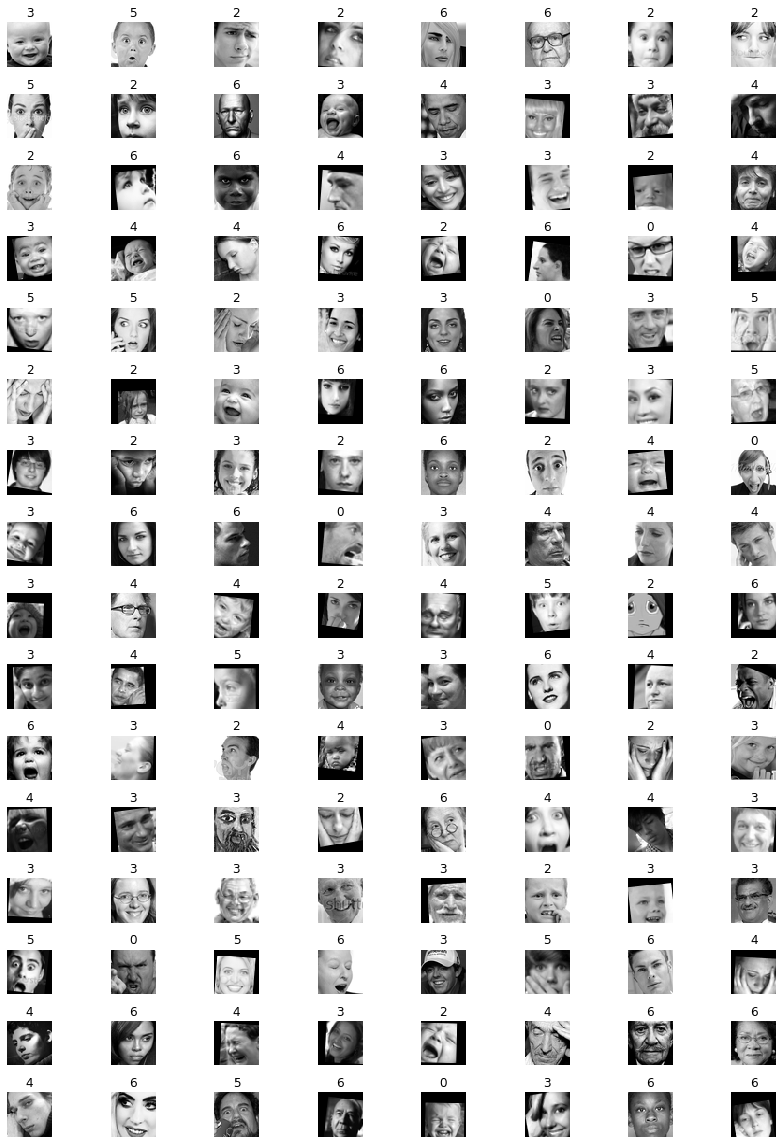

In [37]:
h, w = 16, 8
fig, axs = plt.subplots(h, w, figsize=(12, 16))
for i, image in enumerate(images):
    axs[i // w, i % w].imshow(image[0], cmap='gray')
    axs[i // w, i % w].axis('off')
    axs[i // w, i % w].set_title(int(labels[i]))
plt.tight_layout()
plt.show()

In [24]:
128 / 8

16.0

## Vanilla Transformer

In [6]:
class VarEncode(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VarEncode, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=1)
        self.conv1x1_mu = nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0, stride=1)
        self.conv1x1_logstd = nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0, stride=1)
        
    def reparameterize(self, mu, logstd):
        logstd = logstd.clamp(max=MAX_LOGSTD)
        
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
        
    def kl_loss(self, mu, logstd):
        logstd = logstd.clamp(max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))
        
    def forward(self, x):
        x = self.conv1x1(x)
        mu = self.conv1x1_mu(x)
        logstd = self.conv1x1_logstd(x)
        
        z = self.reparameterize(mu, logstd)
        
        return z, self.kl_loss(mu, logstd)

In [8]:
class MultiAtt(nn.Module):
    def __init__(self, in_channels, dim, heads, residual=True):
        super(MultiAtt, self).__init__()
        
        """
        in_channels: D, H, W
        dim: HW -> dim
        heads: # heads
        """
        self.var_encode = VarEncode(in_channels[0], in_channels[0])
        
        self.in_channels = in_channels
        self.dim = dim
        self.head_dim = dim // heads
        self.heads = heads
        self.residual = residual
        
#         self.alphas = nn.Parameter(-5*torch.ones(self.in_channels[0]), requires_grad=True)
        self.alphas = nn.Parameter(torch.tensor(-5.0), requires_grad=True)
        
        self.softmax = nn.Softmax(-1)
        self.in_norm = nn.LayerNorm((in_channels[0], in_channels[1]*in_channels[2]))
        self.in_proj = nn.Linear(in_channels[1]*in_channels[2], 3*dim)
        
        self.out_proj = nn.Linear(dim, dim)
        self.out_norm = nn.LayerNorm((in_channels[0], dim))
        
    def forward(self, x, return_att=False):
        if self.residual:
            x_res = x
            
        x, kl_loss = self.var_encode(x)
        
        x = x.reshape(-1, self.in_channels[0], self.in_channels[1]*self.in_channels[2])
        
        x = self.in_norm(x)
        x = self.in_proj(x)
        x = x.reshape(x.size(0), x.size(1), 3, x.size(-1) // 3)

        
        q, k, v = x[:, :, 0], x[:, :, 1], x[:, :, 2]  
        
        # head, D, head_dim
        q = q.reshape(q.size(0), q.size(1), self.heads, self.head_dim).permute(0,2,1,3)
        k = k.reshape(k.size(0), k.size(1), self.heads, self.head_dim).permute(0,2,1,3)
        v = v.reshape(v.size(0), v.size(1), self.heads, self.head_dim).permute(0,2,1,3)
        
        att = torch.matmul(q, k.permute(0, 1, 3, 2))
        att = att / math.sqrt(att.size(-1))
        att = self.softmax(att)
        
        out = torch.matmul(att, v)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(out.size(0), out.size(1), -1)
        
        out = self.out_proj(out)
        out = self.out_norm(out)
        
        out = out.reshape(out.size(0), out.size(1), self.in_channels[1], self.in_channels[2])
        
        if self.residual:
#             out = (self.alphas.sigmoid()[:,None, None] * out) + ((1 - self.alphas.sigmoid()[:,None,None]) * x_res)
#             out = out + x_res
            out = (self.alphas.sigmoid() * out) + ((1 - self.alphas.sigmoid()) * x_res)
        
        if return_att:
            return out, kl_loss, att
        else:
            return out, kl_loss


## Model

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [71]:
pretrained = models.vgg16_bn()
pretrained

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [81]:
torch.rand(12, 512, 7, 7).flatten(1).size()

torch.Size([12, 25088])

### MultiAtt

In [32]:
class pretrainedVGG(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(pretrainedVGG, self).__init__()
        pretrained = models.vgg16_bn(pretrained=True)
        
        self.pre_conv = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
        self.block1 = pretrained.features[:7]
        self.block2 = pretrained.features[7:14]
        self.block3 = pretrained.features[14:24]
        self.block4 = pretrained.features[24:34]
        self.block5 = pretrained.features[34:]
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(3,3))
        self.classifier = nn.Sequential(nn.Linear(in_features=4608, out_features=1024, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=1024, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=7, bias=True))

        
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.classifier(x)
        
        return x
        

In [10]:
class pretrainedVGG_MultiAtt(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(pretrainedVGG_MultiAtt, self).__init__()
        pretrained = models.vgg16_bn(pretrained=True)
        
        self.pre_conv = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
        self.block1 = pretrained.features[:7]
        self.block2 = pretrained.features[7:14]
        self.block3 = pretrained.features[14:24]
        self.block4 = pretrained.features[24:34]
#         self.block5 = pretrained.features[34:]
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Sequential(nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=7, bias=True))
        
        
#         self.att1 = MultiAtt((64, 32, 32), 32*32, 4)
#         self.att2 = MultiAtt((128, 16, 16), 16*16, 4)
        self.att3 = MultiAtt((256, 8, 8), 8*8, 4)
        self.att4 = MultiAtt((512, 4, 4), 4*4, 1)
#         self.att5 = MultiAtt((512, 3, 3), 3*3, 1)
        
        
        
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.block1(x)
#         x, kl1 = self.att1(x)
        
        x = self.block2(x)
#         x, kl2 = self.att2(x)
        
        x = self.block3(x)
        x, kl3 = self.att3(x)
        
        x = self.block4(x)
        x, kl4 = self.att4(x)
        
#         x = self.block5(x)
#         x, kl5 = self.att5(x)
        
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.classifier(x)
        
        return x, torch.tensor([kl3, kl4]).sum()
        

In [11]:
# class VGG_MultiAtt(nn.Module):
#     def __init__(self, in_channels=1, out_channels=7):
#         super(VGG_MultiAtt, self).__init__()
        
#         self.block1 = BasicBlock(in_channels, 32)
#         self.block2 = BasicBlock(32, 64)
#         self.block3 = BasicBlock(64, 128)
#         self.block4 = BasicBlock(128, 256)
    
# #         self.att1 = MultiAtt((32, 20, 20), 20*20, 5)
# #         self.att2 = MultiAtt((64, 10, 10), 10*10, 5)
#         self.att3 = MultiAtt((128, 5, 5), 5*5, 1)
#         self.att4 = MultiAtt((256, 2, 2), 2*2, 1)
        
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
#         self.flatten = nn.Flatten()
#         self.classifier = nn.Sequential(
#                               nn.Linear(256, 128, bias=True),
#                               nn.BatchNorm1d(128),
#                               nn.ReLU(inplace=True),
#                               nn.Dropout(p=0.5, inplace=False),
                              
#                               nn.Linear(128, 128, bias=True),
#                               nn.BatchNorm1d(128),
#                               nn.ReLU(inplace=True),
#                               nn.Dropout(p=0.5, inplace=False),
        
#                               nn.Linear(128, out_channels, bias=True))
        
#     def forward(self, x):
#         x = self.block1(x)
#         x = self.maxpool(x)
# #         x = self.att1(x)
        
#         x = self.block2(x)
#         x = self.maxpool(x)
# #         x = self.att2(x)
     
#         x = self.block3(x)
#         x = self.maxpool(x)
#         x = self.att3(x)
        
#         x = self.block4(x)
#         x = self.maxpool(x)
#         x = self.att4(x)
        
#         x = self.avgpool(x)
#         x = self.flatten(x)
#         x = self.classifier(x)
        
#         return x

In [11]:
device = torch.device('cuda')
model = pretrainedVGG_MultiAtt().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [11]:
model_path = 'multiatt/vanilla_alphas_multiatt_4_pretrainedmodel.pt'

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.263002872467041 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [01:35<00:00,  4.70it/s]

- Avg.loss: 1.310 | Avg.acc: 0.502



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.173 | Avg. val_acc: 0.550
* Update optimal model
Epoch:  2


Loss=1.2419649362564087 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [01:36<00:00,  4.65it/s]

- Avg.loss: 1.109 | Avg.acc: 0.589


- Avg. val_loss: 1.074 | Avg. val_acc: 0.602


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.2970333099365234 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [01:36<00:00,  4.64it/s]

- Avg.loss: 1.032 | Avg.acc: 0.622


- Avg. val_loss: 1.096 | Avg. val_acc: 0.603


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=0.9163947105407715 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [01:36<00:00,  4.64it/s]

- Avg.loss: 0.980 | Avg.acc: 0.641



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.600
Epoch:  5


Loss=0.8010484576225281 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [01:36<00:00,  4.63it/s]

- Avg.loss: 0.921 | Avg.acc: 0.667


- Avg. val_loss: 1.072 | Avg. val_acc: 0.606


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.8314663171768188 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [01:37<00:00,  4.63it/s]

- Avg.loss: 0.880 | Avg.acc: 0.683


- Avg. val_loss: 0.975 | Avg. val_acc: 0.646


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.8040578365325928 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [01:37<00:00,  4.62it/s]

- Avg.loss: 0.844 | Avg.acc: 0.694



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.028 | Avg. val_acc: 0.643
Epoch:  8


Loss=0.5175729990005493 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [01:36<00:00,  4.63it/s]

- Avg.loss: 0.791 | Avg.acc: 0.714


- Avg. val_loss: 1.018 | Avg. val_acc: 0.650


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.0539371967315674 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [01:36<00:00,  4.63it/s]

- Avg.loss: 0.756 | Avg.acc: 0.729



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.027 | Avg. val_acc: 0.649
Epoch:  10


Loss=0.9688010215759277 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [01:36<00:00,  4.63it/s]

- Avg.loss: 0.710 | Avg.acc: 0.746


- Avg. val_loss: 1.002 | Avg. val_acc: 0.653


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=0.7287778258323669 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [01:37<00:00,  4.63it/s]

- Avg.loss: 0.672 | Avg.acc: 0.759



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.104 | Avg. val_acc: 0.642
Epoch:  12


Loss=0.7801010012626648 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [01:37<00:00,  4.63it/s]

- Avg.loss: 0.624 | Avg.acc: 0.776


- Avg. val_loss: 1.082 | Avg. val_acc: 0.658


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=0.7951909303665161 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [01:37<00:00,  4.63it/s]

- Avg.loss: 0.541 | Avg.acc: 0.810



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.144 | Avg. val_acc: 0.643
Epoch:  15


Loss=0.5238065123558044 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [01:37<00:00,  4.62it/s]

- Avg.loss: 0.506 | Avg.acc: 0.822


- Avg. val_loss: 1.194 | Avg. val_acc: 0.672


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=0.36468473076820374 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [01:37<00:00,  4.63it/s]

- Avg.loss: 0.480 | Avg.acc: 0.833


- Avg. val_loss: 1.181 | Avg. val_acc: 0.678


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=0.2691378593444824 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [01:37<00:00,  4.62it/s]

- Avg.loss: 0.452 | Avg.acc: 0.845


- Avg. val_loss: 1.214 | Avg. val_acc: 0.679


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=0.2844107151031494 Batch_id=16 Accuracy=0.921875:   4%|▎         | 16/449 [00:04<01:33,  4.63it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.2571670711040497 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [01:37<00:00,  4.62it/s]

- Avg.loss: 0.234 | Avg.acc: 0.923


- Avg. val_loss: 1.609 | Avg. val_acc: 0.680


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=0.012821844778954983 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [01:37<00:00,  4.62it/s]     

- Avg.loss: 0.023 | Avg.acc: 0.992


- Avg. val_loss: 2.587 | Avg. val_acc: 0.691
Finished Training


In [19]:
best_acc

0.6960156032320981

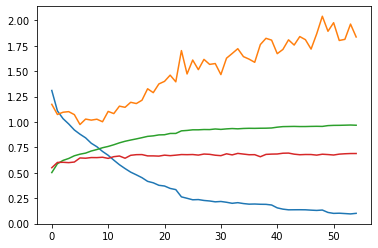

In [14]:
plt.plot(np.array(hist)[:55])

In [17]:
import pickle
pickle.dump(hist, open('multiatt/vanilla_alphas_multiatt_4_pretrainedhist.hdf5', 'wb'))

In [ ]:
MAX_LOGSTD=10
model_path = 'multiatt/vanilla_alphas_varmultiatt_4_4441_pretrainedmodel.pt'

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs)) * kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)
        
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.237930178642273 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [01:02<00:00,  7.16it/s]

- Avg.loss: 1.5061 | Avg.acc: 0.4210



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1601 | Avg. val_acc: 0.5592
* Update optimal model
Epoch:  2


Loss=1.0651708841323853 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [01:02<00:00,  7.15it/s]

- Avg.loss: 1.1205 | Avg.acc: 0.5845


- Avg. val_loss: 1.1341 | Avg. val_acc: 0.5815


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.0318256616592407 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [01:03<00:00,  7.12it/s]

- Avg.loss: 0.9844 | Avg.acc: 0.6419


- Avg. val_loss: 0.9881 | Avg. val_acc: 0.6361


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=0.620718777179718 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [01:03<00:00,  7.12it/s]

- Avg.loss: 0.8783 | Avg.acc: 0.6819


- Avg. val_loss: 0.9704 | Avg. val_acc: 0.6531


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.830957293510437 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [01:03<00:00,  7.09it/s]

- Avg.loss: 0.7849 | Avg.acc: 0.7207


- Avg. val_loss: 0.9997 | Avg. val_acc: 0.6576


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.5453476309776306 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [01:03<00:00,  7.10it/s]

- Avg.loss: 0.7055 | Avg.acc: 0.7473



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1011 | Avg. val_acc: 0.6459
Epoch:  7


Loss=0.70521479845047 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [01:03<00:00,  7.06it/s]

- Avg.loss: 0.6271 | Avg.acc: 0.7776



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0856 | Avg. val_acc: 0.6495
Epoch:  8


Loss=1.0049467086791992 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [01:03<00:00,  7.10it/s]

- Avg.loss: 0.5542 | Avg.acc: 0.8060


- Avg. val_loss: 1.1055 | Avg. val_acc: 0.6709


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=0.5352074503898621 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [01:03<00:00,  7.12it/s]

- Avg.loss: 0.4954 | Avg.acc: 0.8267



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1904 | Avg. val_acc: 0.6606
Epoch:  10


Loss=0.39883771538734436 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [01:03<00:00,  7.10it/s]

- Avg.loss: 0.4482 | Avg.acc: 0.8468



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2194 | Avg. val_acc: 0.6707
Epoch:  11


Loss=0.5221788287162781 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [01:03<00:00,  7.09it/s]

- Avg.loss: 0.4077 | Avg.acc: 0.8607


- Avg. val_loss: 1.2422 | Avg. val_acc: 0.6737


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=0.363535612821579 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [01:03<00:00,  7.09it/s]

- Avg.loss: 0.3722 | Avg.acc: 0.8724



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2436 | Avg. val_acc: 0.6723
Epoch:  13


Loss=0.46502575278282166 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [01:03<00:00,  7.12it/s]

- Avg.loss: 0.3358 | Avg.acc: 0.8868



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3816 | Avg. val_acc: 0.6640
Epoch:  14


Loss=0.21786053478717804 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [01:03<00:00,  7.11it/s]

- Avg.loss: 0.3173 | Avg.acc: 0.8917



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3484 | Avg. val_acc: 0.6701
Epoch:  15


Loss=0.26985666155815125 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [01:03<00:00,  7.08it/s]

- Avg.loss: 0.3018 | Avg.acc: 0.8987


- Avg. val_loss: 1.3605 | Avg. val_acc: 0.6776


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=0.4357801079750061 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [01:03<00:00,  7.08it/s]

- Avg.loss: 0.2839 | Avg.acc: 0.9036



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4300 | Avg. val_acc: 0.6768
Epoch:  17


Loss=0.158035010099411 Batch_id=421 Accuracy=0.953125:  94%|█████████▍| 422/449 [00:59<00:03,  7.13it/s]  

In [23]:
MAX_LOGSTD=10
model_path = 'multiatt/vanilla_singlealphas_varmultiatt_4_0041_pretrainedmodel.pt'

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs)) * kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)
        
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2716342210769653 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:40<00:00, 11.03it/s]

- Avg.loss: 1.4793 | Avg.acc: 0.4121



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2277 | Avg. val_acc: 0.5383
* Update optimal model
Epoch:  2


Loss=0.905748188495636 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:40<00:00, 11.01it/s]

- Avg.loss: 1.1139 | Avg.acc: 0.5757


- Avg. val_loss: 1.0386 | Avg. val_acc: 0.6102


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.1055893898010254 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:40<00:00, 10.99it/s]

- Avg.loss: 0.9648 | Avg.acc: 0.6398


- Avg. val_loss: 1.0161 | Avg. val_acc: 0.6330


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=0.7696743607521057 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:40<00:00, 10.97it/s]

- Avg.loss: 0.8538 | Avg.acc: 0.6876


- Avg. val_loss: 1.0240 | Avg. val_acc: 0.6344


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.7335485816001892 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:41<00:00, 10.92it/s]

- Avg.loss: 0.7647 | Avg.acc: 0.7207


- Avg. val_loss: 1.0027 | Avg. val_acc: 0.6553


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.8170602321624756 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:41<00:00, 10.95it/s]

- Avg.loss: 0.6801 | Avg.acc: 0.7536


- Avg. val_loss: 1.0576 | Avg. val_acc: 0.6598


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.4833536148071289 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.5964 | Avg.acc: 0.7883



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1548 | Avg. val_acc: 0.6364
Epoch:  8


Loss=0.6856741309165955 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]

- Avg.loss: 0.5357 | Avg.acc: 0.8113


- Avg. val_loss: 1.1725 | Avg. val_acc: 0.6668


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=0.47861066460609436 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]

- Avg.loss: 0.4794 | Avg.acc: 0.8294


- Avg. val_loss: 1.1747 | Avg. val_acc: 0.6726


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=0.6935139298439026 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.4220 | Avg.acc: 0.8533


- Avg. val_loss: 1.2475 | Avg. val_acc: 0.6751


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=0.6420961618423462 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:41<00:00, 10.92it/s]

- Avg.loss: 0.3851 | Avg.acc: 0.8669



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2582 | Avg. val_acc: 0.6640
Epoch:  12


Loss=0.2366551011800766 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:40<00:00, 11.00it/s]

- Avg.loss: 0.3544 | Avg.acc: 0.8770



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3091 | Avg. val_acc: 0.6707
Epoch:  13


Loss=0.19742129743099213 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:40<00:00, 10.97it/s]

- Avg.loss: 0.3258 | Avg.acc: 0.8860


- Avg. val_loss: 1.3648 | Avg. val_acc: 0.6765


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=0.28240472078323364 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.3023 | Avg.acc: 0.8946



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4533 | Avg. val_acc: 0.6743
Epoch:  15


Loss=0.21896077692508698 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.95it/s]

- Avg.loss: 0.2849 | Avg.acc: 0.9011



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4833 | Avg. val_acc: 0.6659
Epoch:  16


Loss=0.3339088559150696 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.95it/s]

- Avg.loss: 0.2698 | Avg.acc: 0.9081


- Avg. val_loss: 1.3468 | Avg. val_acc: 0.6773


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=0.4040282964706421 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.2578 | Avg.acc: 0.9114


- Avg. val_loss: 1.4436 | Avg. val_acc: 0.6818


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=0.24703171849250793 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.2459 | Avg.acc: 0.9155



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5002 | Avg. val_acc: 0.6748
Epoch:  19


Loss=0.32192036509513855 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.2364 | Avg.acc: 0.9185



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5667 | Avg. val_acc: 0.6746
Epoch:  20


Loss=0.37843260169029236 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.2230 | Avg.acc: 0.9248


- Avg. val_loss: 1.4779 | Avg. val_acc: 0.6840


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.27564600110054016 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.2194 | Avg.acc: 0.9258



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5433 | Avg. val_acc: 0.6701
Epoch:  22


Loss=0.35163000226020813 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.2147 | Avg.acc: 0.9283



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6318 | Avg. val_acc: 0.6812
Epoch:  23


Loss=0.2246977686882019 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.88it/s]

- Avg.loss: 0.2064 | Avg.acc: 0.9306


- Avg. val_loss: 1.5595 | Avg. val_acc: 0.6849


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=0.14946870505809784 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.1988 | Avg.acc: 0.9330



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5571 | Avg. val_acc: 0.6726
Epoch:  25


Loss=0.1965843141078949 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.87it/s]

- Avg.loss: 0.1913 | Avg.acc: 0.9358



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5884 | Avg. val_acc: 0.6765
Epoch:  26


Loss=0.2929001748561859 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.95it/s]

- Avg.loss: 0.1841 | Avg.acc: 0.9372


- Avg. val_loss: 1.6983 | Avg. val_acc: 0.6871


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=0.31303149461746216 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.1786 | Avg.acc: 0.9394



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5750 | Avg. val_acc: 0.6768
Epoch:  28


Loss=0.13409753143787384 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]

- Avg.loss: 0.1835 | Avg.acc: 0.9368



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7907 | Avg. val_acc: 0.6684
Epoch:  29


Loss=0.10398165136575699 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.1648 | Avg.acc: 0.9441


- Avg. val_loss: 1.6886 | Avg. val_acc: 0.6888


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=0.03599053621292114 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.88it/s]      

- Avg.loss: 0.1722 | Avg.acc: 0.9415



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6617 | Avg. val_acc: 0.6832
Epoch:  31


Loss=0.04521990194916725 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.1588 | Avg.acc: 0.9460



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7705 | Avg. val_acc: 0.6609
Epoch:  32


Loss=0.2073172777891159 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.1569 | Avg.acc: 0.9453



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7010 | Avg. val_acc: 0.6799
Epoch:  33


Loss=0.1496567577123642 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]

- Avg.loss: 0.1608 | Avg.acc: 0.9456



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7895 | Avg. val_acc: 0.6815
Epoch:  34


Loss=0.2343895584344864 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.1511 | Avg.acc: 0.9493



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7510 | Avg. val_acc: 0.6732
Epoch:  35


Loss=0.11898863315582275 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.1527 | Avg.acc: 0.9479



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8029 | Avg. val_acc: 0.6771
Epoch    35: reducing learning rate of group 0 to 7.5000e-05.
Epoch:  36


Loss=0.04872061684727669 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]      

- Avg.loss: 0.1214 | Avg.acc: 0.9588


- Avg. val_loss: 1.8041 | Avg. val_acc: 0.6916


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  37


Loss=0.06544329971075058 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]      

- Avg.loss: 0.1148 | Avg.acc: 0.9612



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8033 | Avg. val_acc: 0.6885
Epoch:  38


Loss=0.23381420969963074 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.88it/s]

- Avg.loss: 0.1193 | Avg.acc: 0.9606



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7910 | Avg. val_acc: 0.6865
Epoch:  39


Loss=0.06957455724477768 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]      

- Avg.loss: 0.1068 | Avg.acc: 0.9640



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0332 | Avg. val_acc: 0.6829
Epoch:  40


Loss=0.07181892544031143 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:40<00:00, 10.96it/s]

- Avg.loss: 0.1118 | Avg.acc: 0.9620



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9136 | Avg. val_acc: 0.6849
Epoch:  41


Loss=0.01709379255771637 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]      

- Avg.loss: 0.1054 | Avg.acc: 0.9643



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8299 | Avg. val_acc: 0.6893
Epoch:  42


Loss=0.20322619378566742 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.1103 | Avg.acc: 0.9626



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8989 | Avg. val_acc: 0.6890
Epoch    42: reducing learning rate of group 0 to 5.6250e-05.
Epoch:  43


Loss=0.2706608474254608 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]

- Avg.loss: 0.0908 | Avg.acc: 0.9680



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9434 | Avg. val_acc: 0.6838
Epoch:  44


Loss=0.08049000054597855 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:40<00:00, 10.97it/s]

- Avg.loss: 0.0898 | Avg.acc: 0.9699


- Avg. val_loss: 1.9646 | Avg. val_acc: 0.6918


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  45


Loss=0.013194079510867596 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]     

- Avg.loss: 0.0862 | Avg.acc: 0.9711



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9991 | Avg. val_acc: 0.6899
Epoch:  46


Loss=0.04383516311645508 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.0817 | Avg.acc: 0.9736



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0038 | Avg. val_acc: 0.6868
Epoch:  47


Loss=0.16658832132816315 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:40<00:00, 10.97it/s]

- Avg.loss: 0.0840 | Avg.acc: 0.9716



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0206 | Avg. val_acc: 0.6865
Epoch:  48


Loss=0.13240192830562592 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.0812 | Avg.acc: 0.9716



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0716 | Avg. val_acc: 0.6893
Epoch:  49


Loss=0.08679066598415375 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]

- Avg.loss: 0.0833 | Avg.acc: 0.9720



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9459 | Avg. val_acc: 0.6882
Epoch:  50


Loss=0.01772400178015232 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.92it/s]      

- Avg.loss: 0.0761 | Avg.acc: 0.9749



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0645 | Avg. val_acc: 0.6846
Epoch    50: reducing learning rate of group 0 to 4.2188e-05.
Epoch:  51


Loss=0.03710044547915459 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.87it/s]      

- Avg.loss: 0.0638 | Avg.acc: 0.9779



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0938 | Avg. val_acc: 0.6885
Epoch:  52


Loss=0.004374430049210787 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.92it/s]     

- Avg.loss: 0.0657 | Avg.acc: 0.9784



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1155 | Avg. val_acc: 0.6913
Epoch:  53


Loss=0.08768845349550247 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.0642 | Avg.acc: 0.9781



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1942 | Avg. val_acc: 0.6871
Epoch:  54


Loss=0.08478574454784393 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.0666 | Avg.acc: 0.9775


- Avg. val_loss: 2.0850 | Avg. val_acc: 0.6927


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  55


Loss=0.04369114711880684 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.0595 | Avg.acc: 0.9797


- Avg. val_loss: 2.1176 | Avg. val_acc: 0.6938


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  56


Loss=0.023138578981161118 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.0615 | Avg.acc: 0.9781



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0964 | Avg. val_acc: 0.6896
Epoch:  57


Loss=0.04628884047269821 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:40<00:00, 10.96it/s]

- Avg.loss: 0.0568 | Avg.acc: 0.9800



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1167 | Avg. val_acc: 0.6874
Epoch:  58


Loss=0.012243437580764294 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]     

- Avg.loss: 0.0596 | Avg.acc: 0.9796


- Avg. val_loss: 2.2277 | Avg. val_acc: 0.6960


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  59


Loss=0.1125936508178711 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.0589 | Avg.acc: 0.9803



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2052 | Avg. val_acc: 0.6949
Epoch:  60


Loss=0.026153214275836945 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]     

- Avg.loss: 0.0582 | Avg.acc: 0.9791



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1329 | Avg. val_acc: 0.6871
Epoch:  61


Loss=0.08483175933361053 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.0595 | Avg.acc: 0.9789



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1465 | Avg. val_acc: 0.6899
Epoch:  62


Loss=0.16221852600574493 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.87it/s]

- Avg.loss: 0.0544 | Avg.acc: 0.9805



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1734 | Avg. val_acc: 0.6818
Epoch:  63


Loss=0.08345016092061996 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.0592 | Avg.acc: 0.9791



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0938 | Avg. val_acc: 0.6826
Epoch:  64


Loss=0.1331869214773178 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:40<00:00, 10.95it/s]

- Avg.loss: 0.0558 | Avg.acc: 0.9811



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1486 | Avg. val_acc: 0.6860
Epoch    64: reducing learning rate of group 0 to 3.1641e-05.
Epoch:  65


Loss=0.026500852778553963 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.92it/s]

- Avg.loss: 0.0492 | Avg.acc: 0.9834



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1143 | Avg. val_acc: 0.6896
Epoch:  66


Loss=0.014386565424501896 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:40<00:00, 10.97it/s]     

- Avg.loss: 0.0473 | Avg.acc: 0.9824



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1949 | Avg. val_acc: 0.6868
Epoch:  67


Loss=0.1914927363395691 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.0479 | Avg.acc: 0.9837


- Avg. val_loss: 2.1750 | Avg. val_acc: 0.6974


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  68


Loss=0.0710858628153801 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.0440 | Avg.acc: 0.9848



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2475 | Avg. val_acc: 0.6924
Epoch:  69


Loss=0.004406430292874575 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]     

- Avg.loss: 0.0443 | Avg.acc: 0.9835



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2506 | Avg. val_acc: 0.6932
Epoch:  70


Loss=0.009292352944612503 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:40<00:00, 10.95it/s]     

- Avg.loss: 0.0469 | Avg.acc: 0.9843



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2227 | Avg. val_acc: 0.6907
Epoch:  71


Loss=0.07200901210308075 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]

- Avg.loss: 0.0485 | Avg.acc: 0.9828



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1728 | Avg. val_acc: 0.6921
Epoch:  72


Loss=0.035675279796123505 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.0438 | Avg.acc: 0.9851



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2077 | Avg. val_acc: 0.6910
Epoch:  73


Loss=0.01092537958174944 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]      

- Avg.loss: 0.0453 | Avg.acc: 0.9842



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1950 | Avg. val_acc: 0.6957
Epoch    73: reducing learning rate of group 0 to 2.3730e-05.
Epoch:  74


Loss=0.006842033471912146 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.92it/s]     

- Avg.loss: 0.0419 | Avg.acc: 0.9858



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2011 | Avg. val_acc: 0.6910
Epoch:  75


Loss=0.029871631413698196 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]

- Avg.loss: 0.0420 | Avg.acc: 0.9848



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2526 | Avg. val_acc: 0.6918
Epoch:  76


Loss=0.034184593707323074 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.92it/s]     

- Avg.loss: 0.0386 | Avg.acc: 0.9861



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2652 | Avg. val_acc: 0.6907
Epoch:  77


Loss=0.047349248081445694 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.89it/s]

- Avg.loss: 0.0381 | Avg.acc: 0.9867



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2651 | Avg. val_acc: 0.6949
Epoch:  78


Loss=0.15740379691123962 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.92it/s]

- Avg.loss: 0.0388 | Avg.acc: 0.9868



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2180 | Avg. val_acc: 0.6927
Epoch:  79


Loss=0.007449834607541561 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.88it/s]     

- Avg.loss: 0.0365 | Avg.acc: 0.9874



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2286 | Avg. val_acc: 0.6921
Epoch    79: reducing learning rate of group 0 to 1.7798e-05.
Epoch:  80


Loss=0.05187813937664032 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.92it/s]

- Avg.loss: 0.0355 | Avg.acc: 0.9868


- Avg. val_loss: 2.2579 | Avg. val_acc: 0.6982


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  81


Loss=0.01604701392352581 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]      

- Avg.loss: 0.0329 | Avg.acc: 0.9883



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3202 | Avg. val_acc: 0.6907
Epoch:  82


Loss=0.02572275698184967 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]

- Avg.loss: 0.0345 | Avg.acc: 0.9880



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3005 | Avg. val_acc: 0.6966
Epoch:  83


Loss=0.017657369375228882 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.89it/s]     

- Avg.loss: 0.0332 | Avg.acc: 0.9878



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3355 | Avg. val_acc: 0.6966
Epoch:  84


Loss=0.03415433689951897 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.0372 | Avg.acc: 0.9871



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2770 | Avg. val_acc: 0.6932
Epoch:  85


Loss=0.023232698440551758 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.89it/s]     

- Avg.loss: 0.0323 | Avg.acc: 0.9890



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2694 | Avg. val_acc: 0.6943
Epoch:  86


Loss=0.003472495824098587 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]     

- Avg.loss: 0.0344 | Avg.acc: 0.9878



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2549 | Avg. val_acc: 0.6966
Epoch    86: reducing learning rate of group 0 to 1.3348e-05.
Epoch:  87


Loss=0.1572882980108261 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]

- Avg.loss: 0.0316 | Avg.acc: 0.9887



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3220 | Avg. val_acc: 0.6943
Epoch:  88


Loss=0.003912393469363451 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.90it/s]     

- Avg.loss: 0.0293 | Avg.acc: 0.9893



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2968 | Avg. val_acc: 0.6938
Epoch:  89


Loss=0.01266087219119072 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:40<00:00, 10.96it/s]      

- Avg.loss: 0.0322 | Avg.acc: 0.9879



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3047 | Avg. val_acc: 0.6966
Epoch:  90


Loss=0.05168363079428673 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.88it/s]

- Avg.loss: 0.0299 | Avg.acc: 0.9891



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3125 | Avg. val_acc: 0.6938
Epoch:  91


Loss=0.0036600413732230663 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]    

- Avg.loss: 0.0296 | Avg.acc: 0.9894


- Avg. val_loss: 2.3331 | Avg. val_acc: 0.6985


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  92


Loss=0.060530222952365875 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.89it/s]

- Avg.loss: 0.0286 | Avg.acc: 0.9898



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2903 | Avg. val_acc: 0.6966
Epoch:  93


Loss=0.001516271149739623 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.89it/s]     

- Avg.loss: 0.0277 | Avg.acc: 0.9898



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3533 | Avg. val_acc: 0.6932
Epoch:  94


Loss=0.003686638781800866 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:40<00:00, 11.02it/s]     

- Avg.loss: 0.0265 | Avg.acc: 0.9898



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3063 | Avg. val_acc: 0.6949
Epoch:  95


Loss=0.06723745912313461 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:41<00:00, 10.91it/s]

- Avg.loss: 0.0294 | Avg.acc: 0.9890



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3791 | Avg. val_acc: 0.6910
Epoch:  96


Loss=0.007446755655109882 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.92it/s]     

- Avg.loss: 0.0288 | Avg.acc: 0.9900



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3310 | Avg. val_acc: 0.6943
Epoch:  97


Loss=0.020964115858078003 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]     

- Avg.loss: 0.0279 | Avg.acc: 0.9904



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3879 | Avg. val_acc: 0.6941
Epoch    97: reducing learning rate of group 0 to 1.0011e-05.
Epoch:  98


Loss=0.03226350620388985 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.94it/s]      

- Avg.loss: 0.0289 | Avg.acc: 0.9892



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3500 | Avg. val_acc: 0.6893
Epoch:  99


Loss=0.012334093451499939 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.89it/s]     

- Avg.loss: 0.0252 | Avg.acc: 0.9905



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3764 | Avg. val_acc: 0.6902
Epoch:  100


Loss=0.017511099576950073 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:41<00:00, 10.93it/s]     

- Avg.loss: 0.0266 | Avg.acc: 0.9897


- Avg. val_loss: 2.3828 | Avg. val_acc: 0.6932
Finished Training


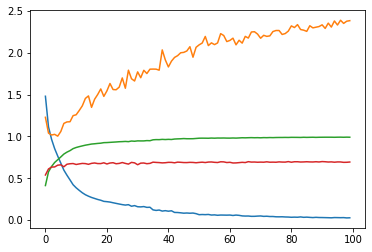

In [24]:
plt.plot(hist)

In [25]:
import pickle
pickle.dump(hist, open('multiatt/vanilla_singlealphas_varmultiatt_4_0041_pretrainedhist.pt', 'wb'))

In [5]:
# EVALUATE
def test(model, test_loader,device):
    model = model.to(device)
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        print('- batch ', i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)

        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))
    
    return running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)

In [19]:
## Test
MAX_LOGSTD=10
device = torch.device('cuda')
model = torch.load('multiatt/vanilla_alphas_varmultiatt_4_pretrainedmodel.pt')

test(model, test_loader, device)

- Avg. val_loss: 1.886 | Avg. val_acc: 0.713


(1.8864837881913588, 0.7127333519086096)

In [15]:
## Test
MAX_LOGSTD=10
device = torch.device('cuda')
model = torch.load('multiatt/vanilla_alphas_varmultiatt_4_4441_pretrainedmodel.pt')

test(model, test_loader, device)

- Avg. val_loss: 2.0087 | Avg. val_acc: 0.7094


(2.0086911175120803, 0.7093898021733074)

In [27]:
## Test
MAX_LOGSTD=10
device = torch.device('cuda')
model = torch.load('multiatt/vanilla_singlealphas_varmultiatt_4_0041_pretrainedmodel.pt')

test(model, test_loader, device)

- Avg. val_loss: 2.1038 | Avg. val_acc: 0.7133


(2.1038190721687036, 0.7132906101978267)

## Squeeze and excitation

In [6]:
class SamplingDepth(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(SamplingDepth, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_channels, out_channels)
        self.dropout = nn.Dropout(dropout, inplace=False)
        
        # options
#         self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()
        
    def forward(self, x):
        x = self.global_pool(x)
        x = nn.Flatten()(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activation(x)
        
        return x

In [7]:
class SamplingSize(nn.Module):
    def __init__(self, size, depth):
        super(SamplingSize, self).__init__()
        
        self.size = size
        self.conv1x1 = nn.Conv2d(depth, 1, kernel_size=1, padding=0, stride=1)
        self.fc = nn.Linear(size[0]*size[1], size[0]*size[1])
        
         # options
        # self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()

    def forward(self, x):
        x = self.conv1x1(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        x = self.activation(x)
        
        x = x.reshape(-1, 1, self.size[0], self.size[1])
        
        return x
        

In [8]:
MAX_LOGSTD = 10
class SamplingLatentSpace(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingLatentSpace, self).__init__()
        
        
        self.in_size = in_size
        self.out_size = out_size

        self.relu = nn.ReLU()
        
        self.encode_conv = nn.Conv2d(in_size[0], out_size[0], kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.dim = out_size[0] * out_size[1] * out_size[2]
        self.fc_mu = nn.Linear(self.dim, self.dim)
        self.fc_logvar = nn.Linear(self.dim, self.dim)
        
        # self.decode_fc = nn.Linear(dim, fdim)
        # self.decode_conv = nn.ConvTranspose2d(mid_dim, in_size[0], kernel_size=3, padding=1)
        
    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(logvar / 2)
    #     eps = torch.randn_like(std)
        
    #     return mu + std*eps

    def reparameterize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def kl_loss(self, mu, logstd):
        logstd = logstd.clamp(max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))
        
    def forward(self, x):
        
        # encode
        _x = self.encode_conv(x)
        _x = self.relu(_x)

        # _x = self.avgpool(x)
        _x = self.flatten(_x)
        
        x_mu = self.fc_mu(_x)
        x_logvar = self.fc_logvar(_x)
        
        # sampling
        z = self.reparameterize(x_mu, x_logvar)

        # reshape
        z = z.reshape(-1, self.out_size[0], self.out_size[1], self.out_size[2])
        
        return z, self.kl_loss(x_mu, x_logvar)
        

In [9]:
class SamplingAtt(nn.Module):
    def __init__(self, in_size, out_size):
        super(SamplingAtt, self).__init__()

        self.f_depth = SamplingDepth(in_size[0], out_size[0])
        self.f_spatial = SamplingSize((in_size[1], out_size[1]), out_size[0])
        self.f_sampling = SamplingLatentSpace(in_size, out_size)

        self.lambd = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        x_depth = self.f_depth(x)
        x_spatial = self.f_spatial(x)

#         z, kl_loss = self.f_sampling(x)
        z = x
        out = (self.lambd*(z*x_depth[:,:,None,None])) + ((1 - self.lambd)*(z*x_spatial))

#         return out, kl_loss
        return out, 0.0

In [10]:
class pretrainedVGG_MultiAtt(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(pretrainedVGG_MultiAtt, self).__init__()
        pretrained = models.vgg16_bn(pretrained=True)
        
        self.pre_conv = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
        self.block1 = pretrained.features[:7]
        self.block2 = pretrained.features[7:14]
        self.block3 = pretrained.features[14:24]
        self.block4 = pretrained.features[24:34]
#         self.block5 = pretrained.features[34:]
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Sequential(nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=7, bias=True))
        
        
        self.att3 = SamplingAtt((256, 8, 8), (256, 8, 8))
        self.att4 = SamplingAtt((512, 4, 4), (512, 4, 4))
        
        
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.block1(x)
        
        x = self.block2(x)
        
        x = self.block3(x)
        x, kl3 = self.att3(x)
        
        x = self.block4(x)
        x, kl4 = self.att4(x)
        
#         x = self.block5(x)
#         x, kl5 = self.att5(x)
        
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.classifier(x)
        
        return x, torch.tensor([kl3, kl4]).sum()
        

In [11]:
device = torch.device('cuda')
model = pretrainedVGG_MultiAtt().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [ ]:
MAX_LOGSTD=10
model_path = 'squeeze_excit_model/sqeeuze_excit_model.pt'

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs)) * kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)
        
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.1778180599212646 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:31<00:00, 14.14it/s]

- Avg.loss: 1.5003 | Avg.acc: 0.3827


- Avg. val_loss: 1.2444 | Avg. val_acc: 0.5213


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.2719272375106812 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:31<00:00, 14.08it/s]

- Avg.loss: 1.1294 | Avg.acc: 0.5658


- Avg. val_loss: 1.1319 | Avg. val_acc: 0.5773


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.6257495284080505 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:31<00:00, 14.07it/s]

- Avg.loss: 0.9912 | Avg.acc: 0.6316


- Avg. val_loss: 1.0209 | Avg. val_acc: 0.6202


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.0452449321746826 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:31<00:00, 14.03it/s]

- Avg.loss: 0.8783 | Avg.acc: 0.6786


- Avg. val_loss: 0.9774 | Avg. val_acc: 0.6470


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.5417695045471191 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:31<00:00, 14.05it/s]

- Avg.loss: 0.7847 | Avg.acc: 0.7160


- Avg. val_loss: 0.9971 | Avg. val_acc: 0.6545


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.9093051552772522 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:31<00:00, 14.09it/s]

- Avg.loss: 0.7049 | Avg.acc: 0.7476


- Avg. val_loss: 1.0272 | Avg. val_acc: 0.6570


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.5841787457466125 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:32<00:00, 13.97it/s]

- Avg.loss: 0.6282 | Avg.acc: 0.7763


- Avg. val_loss: 1.0608 | Avg. val_acc: 0.6612


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=0.4418383538722992 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:32<00:00, 14.02it/s]

- Avg.loss: 0.5577 | Avg.acc: 0.8020


- Avg. val_loss: 1.1526 | Avg. val_acc: 0.6723


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=0.5781296491622925 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]

- Avg.loss: 0.4940 | Avg.acc: 0.8249



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2363 | Avg. val_acc: 0.6617
Epoch:  10


Loss=0.21174883842468262 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:32<00:00, 13.98it/s]

- Avg.loss: 0.4466 | Avg.acc: 0.8432


- Avg. val_loss: 1.2294 | Avg. val_acc: 0.6790


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=0.21018293499946594 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:32<00:00, 13.99it/s]

- Avg.loss: 0.3975 | Avg.acc: 0.8620



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3375 | Avg. val_acc: 0.6668
Epoch:  12


Loss=0.27749720215797424 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:32<00:00, 14.01it/s]

- Avg.loss: 0.3661 | Avg.acc: 0.8732



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3056 | Avg. val_acc: 0.6712
Epoch:  13


Loss=0.3357543647289276 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:32<00:00, 13.97it/s]

- Avg.loss: 0.3390 | Avg.acc: 0.8822



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3538 | Avg. val_acc: 0.6690
Epoch:  14


Loss=0.48945194482803345 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:32<00:00, 13.93it/s]

- Avg.loss: 0.3133 | Avg.acc: 0.8920



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4366 | Avg. val_acc: 0.6665
Epoch:  15


Loss=0.21309775114059448 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:32<00:00, 13.93it/s]

- Avg.loss: 0.2901 | Avg.acc: 0.9008



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5483 | Avg. val_acc: 0.6670
Epoch:  16


Loss=0.3130444586277008 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:32<00:00, 14.01it/s]

- Avg.loss: 0.2854 | Avg.acc: 0.9032



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4622 | Avg. val_acc: 0.6760
Epoch    16: reducing learning rate of group 0 to 7.5000e-05.
Epoch:  17


Loss=0.28303417563438416 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:32<00:00, 13.93it/s]

- Avg.loss: 0.2324 | Avg.acc: 0.9202



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5452 | Avg. val_acc: 0.6718
Epoch:  18


Loss=0.18089190125465393 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.93it/s]

- Avg.loss: 0.2177 | Avg.acc: 0.9265


- Avg. val_loss: 1.5447 | Avg. val_acc: 0.6843


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=0.10984687507152557 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.98it/s]

- Avg.loss: 0.2074 | Avg.acc: 0.9295



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6528 | Avg. val_acc: 0.6746
Epoch:  20


Loss=0.0733899399638176 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]

- Avg.loss: 0.1949 | Avg.acc: 0.9344



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6617 | Avg. val_acc: 0.6782
Epoch:  21


Loss=0.17862136662006378 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.94it/s]

- Avg.loss: 0.1895 | Avg.acc: 0.9365



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6901 | Avg. val_acc: 0.6729
Epoch:  22


Loss=0.1624699980020523 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:32<00:00, 13.94it/s]

- Avg.loss: 0.1804 | Avg.acc: 0.9396



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6528 | Avg. val_acc: 0.6740
Epoch:  23


Loss=0.10936067253351212 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.87it/s]

- Avg.loss: 0.1824 | Avg.acc: 0.9395



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7301 | Avg. val_acc: 0.6757
Epoch:  24


Loss=0.3488740622997284 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:32<00:00, 13.86it/s]

- Avg.loss: 0.1690 | Avg.acc: 0.9443



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6555 | Avg. val_acc: 0.6812
Epoch    24: reducing learning rate of group 0 to 5.6250e-05.
Epoch:  25


Loss=0.0634099543094635 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.93it/s]

- Avg.loss: 0.1515 | Avg.acc: 0.9490


- Avg. val_loss: 1.6769 | Avg. val_acc: 0.6851


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  26


Loss=0.18996195495128632 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:32<00:00, 13.94it/s]

- Avg.loss: 0.1350 | Avg.acc: 0.9546



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8172 | Avg. val_acc: 0.6815
Epoch:  27


Loss=0.09056556969881058 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.95it/s]      

- Avg.loss: 0.1343 | Avg.acc: 0.9555


- Avg. val_loss: 1.8030 | Avg. val_acc: 0.6857


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=0.28620409965515137 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:32<00:00, 14.02it/s]

- Avg.loss: 0.1336 | Avg.acc: 0.9555


- Avg. val_loss: 1.7569 | Avg. val_acc: 0.6904


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=0.25972288846969604 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.99it/s]

- Avg.loss: 0.1257 | Avg.acc: 0.9588



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8508 | Avg. val_acc: 0.6793
Epoch:  30


Loss=0.03636465594172478 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]      

- Avg.loss: 0.1294 | Avg.acc: 0.9572



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7490 | Avg. val_acc: 0.6832
Epoch:  31


Loss=0.07356582581996918 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.94it/s]

- Avg.loss: 0.1271 | Avg.acc: 0.9577



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8072 | Avg. val_acc: 0.6776
Epoch:  32


Loss=0.05781559646129608 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]

- Avg.loss: 0.1296 | Avg.acc: 0.9576



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7603 | Avg. val_acc: 0.6818
Epoch:  33


Loss=0.14514802396297455 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.94it/s]

- Avg.loss: 0.1120 | Avg.acc: 0.9626



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9328 | Avg. val_acc: 0.6821
Epoch:  34


Loss=0.21324944496154785 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.89it/s]

- Avg.loss: 0.1169 | Avg.acc: 0.9607



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8432 | Avg. val_acc: 0.6743
Epoch    34: reducing learning rate of group 0 to 4.2188e-05.
Epoch:  35


Loss=0.18892569839954376 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.93it/s]

- Avg.loss: 0.1093 | Avg.acc: 0.9646



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8072 | Avg. val_acc: 0.6849
Epoch:  36


Loss=0.15854670107364655 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.97it/s]

- Avg.loss: 0.0988 | Avg.acc: 0.9666



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8798 | Avg. val_acc: 0.6882
Epoch:  37


Loss=0.04150358587503433 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]      

- Avg.loss: 0.0905 | Avg.acc: 0.9693



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9383 | Avg. val_acc: 0.6857
Epoch:  38


Loss=0.2615571618080139 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:32<00:00, 13.93it/s]

- Avg.loss: 0.0947 | Avg.acc: 0.9689



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9323 | Avg. val_acc: 0.6899
Epoch:  39


Loss=0.11204216629266739 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]

- Avg.loss: 0.0921 | Avg.acc: 0.9686



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8712 | Avg. val_acc: 0.6849
Epoch:  40


Loss=0.19923706352710724 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.85it/s]

- Avg.loss: 0.0890 | Avg.acc: 0.9694



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9649 | Avg. val_acc: 0.6849
Epoch    40: reducing learning rate of group 0 to 3.1641e-05.
Epoch:  41


Loss=0.12405700981616974 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.85it/s]

- Avg.loss: 0.0830 | Avg.acc: 0.9728



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9413 | Avg. val_acc: 0.6807
Epoch:  42


Loss=0.18778836727142334 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.86it/s]

- Avg.loss: 0.0742 | Avg.acc: 0.9750



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0561 | Avg. val_acc: 0.6902
Epoch:  43


Loss=0.019331688061356544 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.89it/s]     

- Avg.loss: 0.0750 | Avg.acc: 0.9758



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0681 | Avg. val_acc: 0.6840
Epoch:  44


Loss=0.028324175626039505 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]     

- Avg.loss: 0.0734 | Avg.acc: 0.9745



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9842 | Avg. val_acc: 0.6879
Epoch:  45


Loss=0.03645054250955582 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.87it/s]      

- Avg.loss: 0.0718 | Avg.acc: 0.9759



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0316 | Avg. val_acc: 0.6804
Epoch:  46


Loss=0.015418562106788158 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.89it/s]     

- Avg.loss: 0.0695 | Avg.acc: 0.9756



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0353 | Avg. val_acc: 0.6885
Epoch    46: reducing learning rate of group 0 to 2.3730e-05.
Epoch:  47


Loss=0.0660761147737503 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.90it/s]

- Avg.loss: 0.0640 | Avg.acc: 0.9784


- Avg. val_loss: 2.0820 | Avg. val_acc: 0.6935


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  48


Loss=0.035431064665317535 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.91it/s]

- Avg.loss: 0.0662 | Avg.acc: 0.9775



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0600 | Avg. val_acc: 0.6890
Epoch:  49


Loss=0.08773473650217056 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.98it/s]

- Avg.loss: 0.0642 | Avg.acc: 0.9782



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0727 | Avg. val_acc: 0.6927
Epoch:  50


Loss=0.15205198526382446 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.93it/s]

- Avg.loss: 0.0597 | Avg.acc: 0.9796



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0671 | Avg. val_acc: 0.6896
Epoch:  51


Loss=0.04173633083701134 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.89it/s]

- Avg.loss: 0.0569 | Avg.acc: 0.9809



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0887 | Avg. val_acc: 0.6893
Epoch:  52


Loss=0.14534303545951843 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.87it/s]

- Avg.loss: 0.0572 | Avg.acc: 0.9804



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1135 | Avg. val_acc: 0.6935
Epoch:  53


Loss=0.026312846690416336 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]     

- Avg.loss: 0.0570 | Avg.acc: 0.9803



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1143 | Avg. val_acc: 0.6910
Epoch    53: reducing learning rate of group 0 to 1.7798e-05.
Epoch:  54


Loss=0.08603981137275696 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.89it/s]

- Avg.loss: 0.0552 | Avg.acc: 0.9815



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1128 | Avg. val_acc: 0.6930
Epoch:  55


Loss=0.01947779580950737 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.91it/s]      

- Avg.loss: 0.0520 | Avg.acc: 0.9822



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0353 | Avg. val_acc: 0.6935
Epoch:  56


Loss=0.031095942482352257 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.87it/s]     

- Avg.loss: 0.0472 | Avg.acc: 0.9846


- Avg. val_loss: 2.1404 | Avg. val_acc: 0.6985


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  57


Loss=0.08278211951255798 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]

- Avg.loss: 0.0511 | Avg.acc: 0.9815



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1119 | Avg. val_acc: 0.6943
Epoch:  58


Loss=0.002717577386647463 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.91it/s]     

- Avg.loss: 0.0468 | Avg.acc: 0.9836



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1476 | Avg. val_acc: 0.6938
Epoch:  59


Loss=0.019584499299526215 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]     

- Avg.loss: 0.0494 | Avg.acc: 0.9833



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1521 | Avg. val_acc: 0.6927
Epoch:  60


Loss=0.028168868273496628 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.91it/s]     

- Avg.loss: 0.0494 | Avg.acc: 0.9825



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1778 | Avg. val_acc: 0.6952
Epoch:  61


Loss=0.027611607685685158 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.89it/s]     

- Avg.loss: 0.0475 | Avg.acc: 0.9836



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1690 | Avg. val_acc: 0.6927
Epoch:  62


Loss=0.002023747656494379 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.91it/s]     

- Avg.loss: 0.0433 | Avg.acc: 0.9845



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1515 | Avg. val_acc: 0.6907
Epoch    62: reducing learning rate of group 0 to 1.3348e-05.
Epoch:  63


Loss=0.025432216003537178 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]     

- Avg.loss: 0.0457 | Avg.acc: 0.9848



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1642 | Avg. val_acc: 0.6927
Epoch:  64


Loss=0.04336763918399811 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.84it/s]

- Avg.loss: 0.0413 | Avg.acc: 0.9863



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2150 | Avg. val_acc: 0.6874
Epoch:  65


Loss=0.0070081730373203754 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]    

- Avg.loss: 0.0420 | Avg.acc: 0.9861



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1503 | Avg. val_acc: 0.6910
Epoch:  66


Loss=0.10025332123041153 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.95it/s]

- Avg.loss: 0.0418 | Avg.acc: 0.9862



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2145 | Avg. val_acc: 0.6924
Epoch:  67


Loss=0.008300364017486572 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]     

- Avg.loss: 0.0430 | Avg.acc: 0.9853



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1822 | Avg. val_acc: 0.6918
Epoch:  68


Loss=0.013747473247349262 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.85it/s]     

- Avg.loss: 0.0399 | Avg.acc: 0.9866



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1888 | Avg. val_acc: 0.6952
Epoch    68: reducing learning rate of group 0 to 1.0011e-05.
Epoch:  69


Loss=0.13981139659881592 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.90it/s]

- Avg.loss: 0.0425 | Avg.acc: 0.9848



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2124 | Avg. val_acc: 0.6952
Epoch:  70


Loss=0.008719464763998985 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.85it/s]     

- Avg.loss: 0.0423 | Avg.acc: 0.9850



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1588 | Avg. val_acc: 0.6927
Epoch:  71


Loss=0.05594019591808319 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.85it/s]

- Avg.loss: 0.0380 | Avg.acc: 0.9865



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1730 | Avg. val_acc: 0.6916
Epoch:  72


Loss=0.22230491042137146 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:32<00:00, 13.84it/s]

- Avg.loss: 0.0365 | Avg.acc: 0.9867



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1841 | Avg. val_acc: 0.6963
Epoch:  73


Loss=0.011679887771606445 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.95it/s]     

- Avg.loss: 0.0354 | Avg.acc: 0.9872



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1973 | Avg. val_acc: 0.6927
Epoch:  74


Loss=0.0190290454775095 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.90it/s]       

- Avg.loss: 0.0384 | Avg.acc: 0.9867



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1944 | Avg. val_acc: 0.6955
Epoch    74: reducing learning rate of group 0 to 7.5085e-06.
Epoch:  75


Loss=0.006844435818493366 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.90it/s]     

- Avg.loss: 0.0343 | Avg.acc: 0.9876



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2351 | Avg. val_acc: 0.6916
Epoch:  76


Loss=0.044195570051670074 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.97it/s]

- Avg.loss: 0.0368 | Avg.acc: 0.9873



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2438 | Avg. val_acc: 0.6910
Epoch:  77


Loss=0.003434582846239209 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]     

- Avg.loss: 0.0340 | Avg.acc: 0.9886



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2394 | Avg. val_acc: 0.6885
Epoch:  78


Loss=0.01120835356414318 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]      

- Avg.loss: 0.0358 | Avg.acc: 0.9867



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2430 | Avg. val_acc: 0.6932
Epoch:  79


Loss=0.0017075220821425319 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.86it/s]    

- Avg.loss: 0.0363 | Avg.acc: 0.9884



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2187 | Avg. val_acc: 0.6888
Epoch:  80


Loss=0.0010836912551894784 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]    

- Avg.loss: 0.0357 | Avg.acc: 0.9872



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2517 | Avg. val_acc: 0.6916
Epoch    80: reducing learning rate of group 0 to 5.6314e-06.
Epoch:  81


Loss=0.0020436609629541636 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.86it/s]    

- Avg.loss: 0.0326 | Avg.acc: 0.9893



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2514 | Avg. val_acc: 0.6916
Epoch:  82


Loss=0.009028795175254345 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.84it/s]     

- Avg.loss: 0.0332 | Avg.acc: 0.9883



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2733 | Avg. val_acc: 0.6913
Epoch:  83


Loss=0.0016700904816389084 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]    

- Avg.loss: 0.0314 | Avg.acc: 0.9889



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2474 | Avg. val_acc: 0.6899
Epoch:  84


Loss=0.05399160832166672 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.84it/s]

- Avg.loss: 0.0312 | Avg.acc: 0.9894



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2301 | Avg. val_acc: 0.6904
Epoch:  85


Loss=0.08659449219703674 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]

- Avg.loss: 0.0323 | Avg.acc: 0.9887



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2447 | Avg. val_acc: 0.6879
Epoch:  86


Loss=0.008890103548765182 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.89it/s]     

- Avg.loss: 0.0339 | Avg.acc: 0.9878



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2505 | Avg. val_acc: 0.6890
Epoch    86: reducing learning rate of group 0 to 4.2235e-06.
Epoch:  87


Loss=0.009251151233911514 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.86it/s]     

- Avg.loss: 0.0310 | Avg.acc: 0.9893



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2810 | Avg. val_acc: 0.6890
Epoch:  88


Loss=0.008468533866107464 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.89it/s]     

- Avg.loss: 0.0298 | Avg.acc: 0.9892



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2856 | Avg. val_acc: 0.6857
Epoch:  89


Loss=0.0015937346033751965 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:32<00:00, 13.76it/s]    

- Avg.loss: 0.0315 | Avg.acc: 0.9887



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2681 | Avg. val_acc: 0.6907
Epoch:  90


Loss=0.025894850492477417 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:32<00:00, 13.89it/s]

- Avg.loss: 0.0306 | Avg.acc: 0.9893



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2831 | Avg. val_acc: 0.6890
Epoch:  91


Loss=0.012796211056411266 Batch_id=288 Accuracy=1.0:  64%|██████▍   | 289/449 [00:20<00:11, 14.02it/s]     

([<matplotlib.lines.Line2D at 0x7f6dcaabe048>,
 0.6985232655335748)

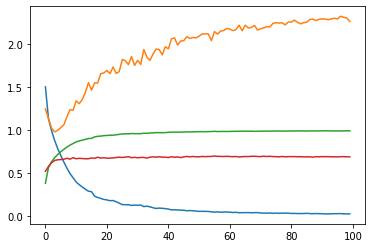

In [14]:
plt.plot(np.array(hist)[:100]), best_acc

In [18]:
import pickle
pickle.dump(hist, open('squeeze_excit_model/sqeeuze_excit_hist.hdf5', 'wb'))

In [13]:
## Test
MAX_LOGSTD=10
device = torch.device('cuda')
model = torch.load('squeeze_excit_model/sqeeuze_excit_model.pt')

test(model, test_loader, device)

- Avg. val_loss: 1.8911 | Avg. val_acc: 0.7228


(1.891052357005634, 0.7227640011145166)

## SE + MultiAtt (MultiAtt inside SE)

In [16]:
class MultiAtt(nn.Module):
    def __init__(self, in_channels, dim, heads, residual=True):
        super(MultiAtt, self).__init__()
        
        """
        in_channels: D, H, W
        dim: HW -> dim
        heads: # heads
        """
#         self.var_encode = VarEncode(in_channels[0], in_channels[0])
        
        self.in_channels = in_channels
        self.dim = dim
        self.head_dim = dim // heads
        self.heads = heads
        self.residual = residual
        
#         self.alphas = nn.Parameter(-5*torch.ones(self.in_channels[0]), requires_grad=True)
#         self.alphas = nn.Parameter(torch.tensor(-5.0), requires_grad=True)
        
        self.softmax = nn.Softmax(-1)
        self.in_norm = nn.LayerNorm((in_channels,))
        self.in_proj = nn.Linear(in_channels, 3*dim)
        
        self.out_proj = nn.Linear(dim, dim)
        self.out_norm = nn.LayerNorm((dim,))
        
    def forward(self, x, return_att=False):
        if self.residual:
            x_res = x
            
#         x, kl_loss = self.var_encode(x)
        
        x = self.in_norm(x)
        x = self.in_proj(x)
        x = x.reshape(x.size(0), 3, -1)
        
        q, k, v = x[:, 0], x[:, 1], x[:, 2]  
        
        # q [12, 4, 64]
        # head, D, head_dim
        q = q.reshape(q.size(0), self.heads, self.head_dim)
        k = k.reshape(k.size(0), self.heads, self.head_dim)
        v = v.reshape(v.size(0), self.heads, self.head_dim)
        
        att = torch.matmul(q.unsqueeze(-1), k.unsqueeze(2))
        att = self.softmax(att)
        
        out = torch.matmul(att, v.unsqueeze(-1))
        out = out.squeeze(-1) # 12, 4, 64
        out = out.reshape(out.size(0), -1)
        
        out = self.out_proj(out)
        out = self.out_norm(out)
        
        if self.residual:
#             out = (self.alphas.sigmoid()[:,None, None] * out) + ((1 - self.alphas.sigmoid()[:,None,None]) * x_res)
            out = out + x_res
#             out = (self.alphas.sigmoid() * out) + ((1 - self.alphas.sigmoid()) * x_res)
        
        if return_att:
            return out, att
        else:
            return out


In [6]:
class SamplingDepth(nn.Module):
    def __init__(self, in_channels, out_channels, heads, residual=True, dropout=0.0):
        super(SamplingDepth, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.att = MultiAtt(in_channels, out_channels, heads, residual)
        
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.global_pool(x)
        x = nn.Flatten()(x)
        
        x = self.att(x)
        x = self.activation(x)
        
        return x

In [7]:
class SamplingSize(nn.Module):
    def __init__(self, size, depth, heads, residual=True):
        super(SamplingSize, self).__init__()
        
        self.size = size
        self.conv1x1 = nn.Conv2d(depth, 1, kernel_size=1, padding=0, stride=1)
        self.att = MultiAtt(size[0]*size[1], size[0]*size[1], heads, residual)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1x1(x)
        x = nn.Flatten()(x)
        x = self.att(x)
        
        x = x.reshape(-1, 1, self.size[0], self.size[1])
        x = self.activation(x)
        
        return x
        

In [8]:
class SamplingAtt(nn.Module):
    def __init__(self, in_size, out_size, depth_heads, spatial_heads):
        super(SamplingAtt, self).__init__()

        self.f_depth = SamplingDepth(in_size[0], out_size[0], depth_heads)
        self.f_spatial = SamplingSize((in_size[1], out_size[1]), out_size[0], spatial_heads)

        self.lambd = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        x_depth = self.f_depth(x)
        x_spatial = self.f_spatial(x)

#         z, kl_loss = self.f_sampling(x)
        z = x
        out = (self.lambd*(z*x_depth[:,:,None,None])) + ((1 - self.lambd)*(z*x_spatial))

#         return out, kl_loss
        return out, 0.0

In [9]:
class pretrainedVGG_MultiAtt(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(pretrainedVGG_MultiAtt, self).__init__()
        pretrained = models.vgg16_bn(pretrained=True)
        
        self.pre_conv = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
        self.block1 = pretrained.features[:7]
        self.block2 = pretrained.features[7:14]
        self.block3 = pretrained.features[14:24]
        self.block4 = pretrained.features[24:34]
#         self.block5 = pretrained.features[34:]
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Sequential(nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=512, bias=True),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=7, bias=True))
        
        
        self.att3 = SamplingAtt((256, 8, 8), (256, 8, 8), depth_heads=4, spatial_heads=1)
        self.att4 = SamplingAtt((512, 4, 4), (512, 4, 4), depth_heads=4, spatial_heads=1)
        
        
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.block1(x)
        
        x = self.block2(x)
        
        x = self.block3(x)
        x, kl3 = self.att3(x)
        
        x = self.block4(x)
        x, kl4 = self.att4(x)
        
#         x = self.block5(x)
#         x, kl5 = self.att5(x)
        
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.classifier(x)
        
        return x, torch.tensor([kl3, kl4]).sum()
        

In [10]:
device = torch.device('cuda')
model = pretrainedVGG_MultiAtt().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [89]:
MAX_LOGSTD=10
model_path = 'squeeze_excit_model/se_multiatt_model.pt'

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs)) * kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss = model(inputs)
        
        loss = criterion(outputs, labels)
        loss = loss + ((1/len(inputs))*kl_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2310521602630615 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:37<00:00, 12.09it/s]

- Avg.loss: 1.5503 | Avg.acc: 0.3552



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2818 | Avg. val_acc: 0.4684
* Update optimal model
Epoch:  2


Loss=1.1341923475265503 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:36<00:00, 12.16it/s]

- Avg.loss: 1.1932 | Avg.acc: 0.5367


- Avg. val_loss: 1.0907 | Avg. val_acc: 0.5848


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.9696030616760254 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:36<00:00, 12.19it/s]

- Avg.loss: 1.0386 | Avg.acc: 0.6111



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1159 | Avg. val_acc: 0.5776
Epoch:  4


Loss=0.953273355960846 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:37<00:00, 12.11it/s]

- Avg.loss: 0.9169 | Avg.acc: 0.6620


- Avg. val_loss: 1.0040 | Avg. val_acc: 0.6333


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.9027845859527588 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:37<00:00, 12.09it/s]

- Avg.loss: 0.8219 | Avg.acc: 0.7014


- Avg. val_loss: 1.0001 | Avg. val_acc: 0.6481


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.8791252374649048 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:37<00:00, 12.11it/s]

- Avg.loss: 0.7310 | Avg.acc: 0.7360


- Avg. val_loss: 1.0599 | Avg. val_acc: 0.6514


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.8552479147911072 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:37<00:00, 12.11it/s]

- Avg.loss: 0.6540 | Avg.acc: 0.7623


- Avg. val_loss: 1.0526 | Avg. val_acc: 0.6601


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=0.6193135380744934 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:37<00:00, 12.00it/s]

- Avg.loss: 0.5767 | Avg.acc: 0.7936


- Avg. val_loss: 1.1108 | Avg. val_acc: 0.6620


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=0.6095065474510193 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:37<00:00, 12.05it/s]

- Avg.loss: 0.5157 | Avg.acc: 0.8181


- Avg. val_loss: 1.1697 | Avg. val_acc: 0.6643


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=0.5824947953224182 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:37<00:00, 12.03it/s]

- Avg.loss: 0.4629 | Avg.acc: 0.8381



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1837 | Avg. val_acc: 0.6631
Epoch:  11


Loss=0.4871096611022949 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:37<00:00, 12.12it/s]

- Avg.loss: 0.4131 | Avg.acc: 0.8567


- Avg. val_loss: 1.2370 | Avg. val_acc: 0.6768


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=0.2044871300458908 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 12.01it/s]

- Avg.loss: 0.3784 | Avg.acc: 0.8669



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2656 | Avg. val_acc: 0.6704
Epoch:  13


Loss=0.22073905169963837 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:37<00:00, 11.97it/s]

- Avg.loss: 0.3481 | Avg.acc: 0.8785



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3433 | Avg. val_acc: 0.6709
Epoch:  14


Loss=0.3023538291454315 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:37<00:00, 12.08it/s]

- Avg.loss: 0.3239 | Avg.acc: 0.8879



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3409 | Avg. val_acc: 0.6768
Epoch:  15


Loss=0.3060409128665924 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:37<00:00, 12.06it/s]

- Avg.loss: 0.2979 | Avg.acc: 0.8996



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4209 | Avg. val_acc: 0.6718
Epoch:  16


Loss=0.41533491015434265 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:37<00:00, 12.05it/s]

- Avg.loss: 0.2785 | Avg.acc: 0.9058



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4062 | Avg. val_acc: 0.6723
Epoch:  17


Loss=0.5455789566040039 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:37<00:00, 11.99it/s]

- Avg.loss: 0.2676 | Avg.acc: 0.9091



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4895 | Avg. val_acc: 0.6659
Epoch    17: reducing learning rate of group 0 to 7.5000e-05.
Epoch:  18


Loss=0.18055997788906097 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.13it/s]

- Avg.loss: 0.2275 | Avg.acc: 0.9224


- Avg. val_loss: 1.6311 | Avg. val_acc: 0.6835


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=0.1671845018863678 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 12.10it/s]

- Avg.loss: 0.2093 | Avg.acc: 0.9293



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5741 | Avg. val_acc: 0.6782
Epoch:  20


Loss=0.41078537702560425 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:37<00:00, 12.10it/s]

- Avg.loss: 0.2029 | Avg.acc: 0.9302



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6762 | Avg. val_acc: 0.6771
Epoch:  21


Loss=0.24377013742923737 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.07it/s]

- Avg.loss: 0.1943 | Avg.acc: 0.9336



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7512 | Avg. val_acc: 0.6656
Epoch:  22


Loss=0.14989930391311646 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 11.99it/s]

- Avg.loss: 0.1870 | Avg.acc: 0.9372



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6645 | Avg. val_acc: 0.6824
Epoch:  23


Loss=0.25471845269203186 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:37<00:00, 12.04it/s]

- Avg.loss: 0.1774 | Avg.acc: 0.9402



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7519 | Avg. val_acc: 0.6734
Epoch:  24


Loss=0.27356934547424316 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:37<00:00, 12.04it/s]

- Avg.loss: 0.1749 | Avg.acc: 0.9424


- Avg. val_loss: 1.7143 | Avg. val_acc: 0.6849


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=0.09406574815511703 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 11.99it/s]

- Avg.loss: 0.1654 | Avg.acc: 0.9436



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6602 | Avg. val_acc: 0.6807
Epoch:  26


Loss=0.14658059179782867 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 12.03it/s]

- Avg.loss: 0.1673 | Avg.acc: 0.9431



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8302 | Avg. val_acc: 0.6737
Epoch:  27


Loss=0.11770258843898773 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.05it/s]

- Avg.loss: 0.1571 | Avg.acc: 0.9467



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7982 | Avg. val_acc: 0.6626
Epoch:  28


Loss=0.09482910484075546 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.04it/s]

- Avg.loss: 0.1582 | Avg.acc: 0.9462



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7501 | Avg. val_acc: 0.6838
Epoch:  29


Loss=0.18064427375793457 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 12.05it/s]

- Avg.loss: 0.1487 | Avg.acc: 0.9496



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7531 | Avg. val_acc: 0.6807
Epoch:  30


Loss=0.134762242436409 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.04it/s]

- Avg.loss: 0.1446 | Avg.acc: 0.9518



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8491 | Avg. val_acc: 0.6799
Epoch    30: reducing learning rate of group 0 to 5.6250e-05.
Epoch:  31


Loss=0.07503783702850342 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.04it/s]

- Avg.loss: 0.1279 | Avg.acc: 0.9571



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8896 | Avg. val_acc: 0.6824
Epoch:  32


Loss=0.10779208689928055 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.04it/s]

- Avg.loss: 0.1197 | Avg.acc: 0.9598



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8584 | Avg. val_acc: 0.6835
Epoch:  33


Loss=0.029125288128852844 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.02it/s]     

- Avg.loss: 0.1182 | Avg.acc: 0.9600



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9236 | Avg. val_acc: 0.6799
Epoch:  34


Loss=0.12135422229766846 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 12.01it/s]

- Avg.loss: 0.1162 | Avg.acc: 0.9615


- Avg. val_loss: 1.7978 | Avg. val_acc: 0.6854


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=0.056759726256132126 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.09it/s]

- Avg.loss: 0.1099 | Avg.acc: 0.9638



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9126 | Avg. val_acc: 0.6796
Epoch:  36


Loss=0.10936073213815689 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 12.01it/s]

- Avg.loss: 0.1049 | Avg.acc: 0.9651



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7966 | Avg. val_acc: 0.6843
Epoch:  37


Loss=0.06714243441820145 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.05it/s]

- Avg.loss: 0.0985 | Avg.acc: 0.9666


- Avg. val_loss: 1.9498 | Avg. val_acc: 0.6890


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  41


Loss=0.2194267213344574 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 12.07it/s]

- Avg.loss: 0.1028 | Avg.acc: 0.9656


- Avg. val_loss: 1.9037 | Avg. val_acc: 0.6955


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  42


Loss=0.057098232209682465 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.11it/s]

- Avg.loss: 0.0976 | Avg.acc: 0.9670



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9845 | Avg. val_acc: 0.6851
Epoch:  43


Loss=0.12294827401638031 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.06it/s]

- Avg.loss: 0.0967 | Avg.acc: 0.9680



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9453 | Avg. val_acc: 0.6854
Epoch:  44


Loss=0.12234460562467575 Batch_id=278 Accuracy=0.953125:  62%|██████▏   | 279/449 [00:23<00:13, 12.21it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.20315280556678772 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:37<00:00, 12.03it/s]

- Avg.loss: 0.0921 | Avg.acc: 0.9690



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9359 | Avg. val_acc: 0.6846
Epoch    47: reducing learning rate of group 0 to 4.2188e-05.
Epoch:  48


Loss=0.018504099920392036 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 11.99it/s]     

- Avg.loss: 0.0804 | Avg.acc: 0.9733



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9789 | Avg. val_acc: 0.6943
Epoch:  49


Loss=0.09030673652887344 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:36<00:00, 12.16it/s]

- Avg.loss: 0.0771 | Avg.acc: 0.9743



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9981 | Avg. val_acc: 0.6907
Epoch:  50


Loss=0.022128935903310776 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.02it/s]     

- Avg.loss: 0.0728 | Avg.acc: 0.9760



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0605 | Avg. val_acc: 0.6913
Epoch:  51


Loss=0.06856389343738556 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.03it/s]

- Avg.loss: 0.0729 | Avg.acc: 0.9759



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1808 | Avg. val_acc: 0.6815
Epoch:  52


Loss=0.019962331280112267 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.03it/s]     

- Avg.loss: 0.0753 | Avg.acc: 0.9740



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9890 | Avg. val_acc: 0.6818
Epoch:  53


Loss=0.037162721157073975 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.11it/s]

- Avg.loss: 0.0693 | Avg.acc: 0.9762



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0758 | Avg. val_acc: 0.6952
Epoch    53: reducing learning rate of group 0 to 3.1641e-05.
Epoch:  54


Loss=0.16461700201034546 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:36<00:00, 12.17it/s]

- Avg.loss: 0.0618 | Avg.acc: 0.9776



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1219 | Avg. val_acc: 0.6943
Epoch:  55


Loss=0.0045071993954479694 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.06it/s]    

- Avg.loss: 0.0596 | Avg.acc: 0.9796



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1359 | Avg. val_acc: 0.6885
Epoch:  56


Loss=0.014206042513251305 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.03it/s]     

- Avg.loss: 0.0596 | Avg.acc: 0.9804



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1618 | Avg. val_acc: 0.6890
Epoch:  57


Loss=0.06012548506259918 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 11.99it/s]      

- Avg.loss: 0.0573 | Avg.acc: 0.9801



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1584 | Avg. val_acc: 0.6896
Epoch:  58


Loss=0.010341038927435875 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.05it/s]     

- Avg.loss: 0.0555 | Avg.acc: 0.9811



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2266 | Avg. val_acc: 0.6826
Epoch:  59


Loss=0.046923067420721054 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.06it/s]

- Avg.loss: 0.0557 | Avg.acc: 0.9804



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2008 | Avg. val_acc: 0.6815
Epoch    59: reducing learning rate of group 0 to 2.3730e-05.
Epoch:  60


Loss=0.009828022681176662 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 11.99it/s]     

- Avg.loss: 0.0520 | Avg.acc: 0.9823



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1650 | Avg. val_acc: 0.6882
Epoch:  61


Loss=0.16146616637706757 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.01it/s]

- Avg.loss: 0.0508 | Avg.acc: 0.9820



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0899 | Avg. val_acc: 0.6849
Epoch:  62


Loss=0.006273301783949137 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.05it/s]     

- Avg.loss: 0.0498 | Avg.acc: 0.9826



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0963 | Avg. val_acc: 0.6904
Epoch:  63


Loss=0.012212550267577171 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.00it/s]     

- Avg.loss: 0.0475 | Avg.acc: 0.9826



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1477 | Avg. val_acc: 0.6918
Epoch:  64


Loss=0.13161523640155792 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.08it/s]

- Avg.loss: 0.0470 | Avg.acc: 0.9832



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1993 | Avg. val_acc: 0.6916
Epoch:  65


Loss=0.0054439520463347435 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.09it/s]    

- Avg.loss: 0.0468 | Avg.acc: 0.9838



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2444 | Avg. val_acc: 0.6888
Epoch    65: reducing learning rate of group 0 to 1.7798e-05.
Epoch:  66


Loss=0.004532350227236748 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 11.96it/s]     

- Avg.loss: 0.0416 | Avg.acc: 0.9867



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2156 | Avg. val_acc: 0.6938
Epoch:  67


Loss=0.17522233724594116 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 12.08it/s]

- Avg.loss: 0.0424 | Avg.acc: 0.9851



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2467 | Avg. val_acc: 0.6916
Epoch:  68


Loss=0.001963614718988538 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.08it/s]     

- Avg.loss: 0.0425 | Avg.acc: 0.9846



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2528 | Avg. val_acc: 0.6904
Epoch:  69


Loss=0.014865179546177387 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.11it/s]     

- Avg.loss: 0.0404 | Avg.acc: 0.9859



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2254 | Avg. val_acc: 0.6927
Epoch:  70


Loss=0.01048364769667387 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.07it/s]      

- Avg.loss: 0.0390 | Avg.acc: 0.9865



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2584 | Avg. val_acc: 0.6927
Epoch:  71


Loss=0.007276440039277077 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.00it/s]     

- Avg.loss: 0.0383 | Avg.acc: 0.9874


- Avg. val_loss: 2.2881 | Avg. val_acc: 0.6969


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  72


Loss=0.0824463814496994 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 12.02it/s]

- Avg.loss: 0.0410 | Avg.acc: 0.9858



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2227 | Avg. val_acc: 0.6918
Epoch:  73


Loss=0.02975001558661461 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.09it/s]

- Avg.loss: 0.0365 | Avg.acc: 0.9867



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2626 | Avg. val_acc: 0.6918
Epoch:  74


Loss=0.003578801406547427 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.13it/s]     

- Avg.loss: 0.0373 | Avg.acc: 0.9871



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3360 | Avg. val_acc: 0.6941
Epoch:  75


Loss=0.003563061822205782 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.00it/s]     

- Avg.loss: 0.0379 | Avg.acc: 0.9862



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3261 | Avg. val_acc: 0.6899
Epoch:  76


Loss=0.05191422626376152 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.06it/s]      

- Avg.loss: 0.0387 | Avg.acc: 0.9866



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2917 | Avg. val_acc: 0.6943
Epoch:  77


Loss=0.004795529413968325 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.02it/s]     

- Avg.loss: 0.0366 | Avg.acc: 0.9877



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3249 | Avg. val_acc: 0.6888
Epoch    77: reducing learning rate of group 0 to 1.3348e-05.
Epoch:  78


Loss=0.08142147958278656 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:37<00:00, 12.01it/s]

- Avg.loss: 0.0343 | Avg.acc: 0.9881



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2893 | Avg. val_acc: 0.6960
Epoch:  79


Loss=0.016157027333974838 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.00it/s]     

- Avg.loss: 0.0332 | Avg.acc: 0.9884



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3054 | Avg. val_acc: 0.6938
Epoch:  80


Loss=0.010175150819122791 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.01it/s]     

- Avg.loss: 0.0337 | Avg.acc: 0.9882



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3121 | Avg. val_acc: 0.6966
Epoch:  81


Loss=0.03437269851565361 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.06it/s]

- Avg.loss: 0.0330 | Avg.acc: 0.9882



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3442 | Avg. val_acc: 0.6927
Epoch:  82


Loss=0.00935722328722477 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.07it/s]      

- Avg.loss: 0.0315 | Avg.acc: 0.9881



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2766 | Avg. val_acc: 0.6930
Epoch:  83


Loss=0.022699080407619476 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.08it/s]

- Avg.loss: 0.0312 | Avg.acc: 0.9887



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.4029 | Avg. val_acc: 0.6960
Epoch    83: reducing learning rate of group 0 to 1.0011e-05.
Epoch:  84


Loss=0.0590357780456543 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 11.98it/s]

- Avg.loss: 0.0332 | Avg.acc: 0.9876


- Avg. val_loss: 2.3311 | Avg. val_acc: 0.7002


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  85


Loss=0.04624126851558685 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.07it/s]

- Avg.loss: 0.0327 | Avg.acc: 0.9878



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3114 | Avg. val_acc: 0.6999
Epoch:  86


Loss=0.04818185418844223 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.03it/s]

- Avg.loss: 0.0302 | Avg.acc: 0.9887



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3308 | Avg. val_acc: 0.6988
Epoch:  87


Loss=0.1475185751914978 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 11.98it/s]

- Avg.loss: 0.0311 | Avg.acc: 0.9885



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3629 | Avg. val_acc: 0.6955
Epoch:  88


Loss=0.0066435858607292175 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.07it/s]    

- Avg.loss: 0.0318 | Avg.acc: 0.9879



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3300 | Avg. val_acc: 0.6969
Epoch:  89


Loss=0.06303684413433075 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:36<00:00, 12.14it/s]

- Avg.loss: 0.0315 | Avg.acc: 0.9890


- Avg. val_loss: 2.3540 | Avg. val_acc: 0.7010


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  90


Loss=0.0017257189610973 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 11.97it/s]       

- Avg.loss: 0.0284 | Avg.acc: 0.9898



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3502 | Avg. val_acc: 0.6957
Epoch:  91


Loss=0.005126922391355038 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.02it/s]     

- Avg.loss: 0.0285 | Avg.acc: 0.9896



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3753 | Avg. val_acc: 0.6916
Epoch:  92


Loss=0.03538811206817627 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 11.95it/s]

- Avg.loss: 0.0279 | Avg.acc: 0.9899



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.4035 | Avg. val_acc: 0.6946
Epoch:  93


Loss=0.03642816096544266 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.03it/s]      

- Avg.loss: 0.0274 | Avg.acc: 0.9897



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3653 | Avg. val_acc: 0.6930
Epoch:  94


Loss=0.003909875173121691 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.00it/s]     

- Avg.loss: 0.0288 | Avg.acc: 0.9890



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3708 | Avg. val_acc: 0.6882
Epoch:  95


Loss=0.0540744885802269 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:37<00:00, 12.09it/s]

- Avg.loss: 0.0270 | Avg.acc: 0.9905



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.4568 | Avg. val_acc: 0.6941
Epoch    95: reducing learning rate of group 0 to 7.5085e-06.
Epoch:  96


Loss=0.01704161986708641 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.01it/s]      

- Avg.loss: 0.0268 | Avg.acc: 0.9897



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.4173 | Avg. val_acc: 0.6935
Epoch:  97


Loss=0.020509857684373856 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.06it/s]     

- Avg.loss: 0.0287 | Avg.acc: 0.9895



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3453 | Avg. val_acc: 0.6952
Epoch:  98


Loss=0.007157470565289259 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.08it/s]     

- Avg.loss: 0.0268 | Avg.acc: 0.9898



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.4197 | Avg. val_acc: 0.6924
Epoch:  99


Loss=0.009796656668186188 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:37<00:00, 12.04it/s]     

- Avg.loss: 0.0266 | Avg.acc: 0.9904



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3670 | Avg. val_acc: 0.6957
Epoch:  100


Loss=0.0006817273679189384 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:36<00:00, 12.14it/s]    

- Avg.loss: 0.0250 | Avg.acc: 0.9914


- Avg. val_loss: 2.3852 | Avg. val_acc: 0.6930
Finished Training


([<matplotlib.lines.Line2D at 0x7f651bb8bf60>,
 0.7010309278350515)

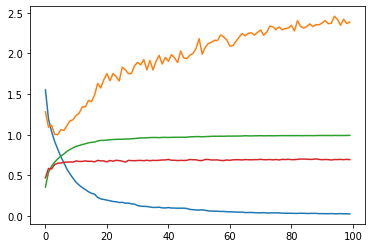

In [90]:
plt.plot(hist), best_acc

In [95]:
import pickle
pickle.dump(hist, open('squeeze_excit_model/se_multiatt_hist.hdf5', 'wb'))

In [92]:
## Test
MAX_LOGSTD=10
device = torch.device('cuda')
test_model = torch.load('squeeze_excit_model/se_multiatt_model.pt')

test(test_model, test_loader, device)

- Avg. val_loss: 2.1900 | Avg. val_acc: 0.7058


(2.189959612567755, 0.7057676232933965)

## Visualization

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

def attention(model, img, lb=None, visual_heatmap=True, ext_output=False, grayscale=True, return_heatmap=False):
    model.eval()
    if ext_output:
        output, _ = model(img.unsqueeze(0))
    else:
        output = model(img.unsqueeze(0))
    prob = nn.Softmax()(output.detach())
    prob = float(prob.max(1)[0][0])
    
    
    pred_lb = int(output.argmax(1)[0])
    
    lb = pred_lb if lb is None else lb
    output[:,lb].backward()

    # get gradient
    grads = gradients['last_conv'][0]
    
    # !!! 2 options
#     pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))

    # get activation
    features = activation['last_conv']

    # weight the channels by corresponding gradients
    print('features: ', features.size())
    print('pooled grads: ', pooled_grads.size())
    
    for i in range(features.size(1)):
        features[:, i, :, :] *= pooled_grads[0,i,:,:]
   
    heatmap = features.detach().numpy()
    heatmap = np.mean(heatmap, axis=1).squeeze()
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
 
    # 1 channel
    if grayscale:
        img = img.numpy()[0]
        img = np.stack((img,)*3, axis=-1)
        
    # 3 channels
    else:
        img = img.numpy().transpose((1,2,0))
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Adjust the size of the heat map to be the same as the original image
    heatmap = np.uint8(255 * heatmap) # Convert the heat map to RGB format
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Apply the heat map to the original image
    heatmap = heatmap[:,:,::-1] #bgr -> rgb
    
    superimposed_img = heatmap * 0.008 + img # here 0.4 is the heat map intensity factor
        
    superimposed_img /= np.max(superimposed_img)
    
    if not return_heatmap:    
        return superimposed_img, pred_lb, int(lb), prob
    
    else:
        return superimposed_img, pred_lb, int(lb), prob, heatmap


# activation = {}
def get_activation(name):
    def hook(model, input, output):
        if name not in activation:
            activation[name] = []

        activation[name].append(output[0].detach())
    return hook

# gradients = {}
def get_gradient(name):
    def hook(model, in_grad, out_grad):
        gradients[name] = out_grad
        
    return hook


In [16]:
activation = {}
gradients = {}


device = torch.device('cpu')
model = torch.load('squeeze_excit_model/sqeeuze_excit_model.pt')
# model = torch.load('multiatt/vanilla_singlealphas_varmultiatt_4_0041_pretrainedmodel.pt')
model = model.to(device)
model.eval()

model.att4.register_forward_hook(get_activation('last_conv'))
# model.att4.register_backward_hook(get_gradient('last_conv'))



In [17]:
test(model, train_loader,device=torch.device('cuda'))

- batch  0
- batch  1
- batch  2
- batch  3
- batch  4
- batch  5
- batch  6
- batch  7
- batch  8
- batch  9
- batch  10
- batch  11
- batch  12
- batch  13
- batch  14
- batch  15
- batch  16
- batch  17
- batch  18
- batch  19
- batch  20
- batch  21
- batch  22
- batch  23
- batch  24
- batch  25
- batch  26
- batch  27
- batch  28
- batch  29
- batch  30
- batch  31
- batch  32
- batch  33
- batch  34
- batch  35
- batch  36
- batch  37
- batch  38
- batch  39
- batch  40
- batch  41
- batch  42
- batch  43
- batch  44
- batch  45
- batch  46
- batch  47
- batch  48
- batch  49
- batch  50
- batch  51
- batch  52
- batch  53
- batch  54
- batch  55
- batch  56
- batch  57
- batch  58
- batch  59
- batch  60
- batch  61
- batch  62
- batch  63
- batch  64
- batch  65
- batch  66
- batch  67
- batch  68
- batch  69
- batch  70
- batch  71
- batch  72
- batch  73
- batch  74
- batch  75
- batch  76
- batch  77
- batch  78
- batch  79
- batch  80
- batch  81
- batch  82
- batch  83
- 

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.79 GiB total capacity; 6.81 GiB already allocated; 11.25 MiB free; 6.84 GiB reserved in total by PyTorch)

In [22]:
from sklearn.manifold import TSNE

def to_tsne(features, data_loader):
    features = nn.AdaptiveAvgPool2d(output_size=(1,1))(features).flatten(1)
    features = features.detach().cpu()
    labels = torch.cat([k[1] for k in data_loader])
    label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
    str_labels = [label_dict[int(k)] for k in labels]
    tsne_features = TSNE(n_components=2).fit_transform(features.numpy())
    
    return tsne_features, str_labels, labels

# features = torch.cat(activation['last_conv'])
# tsne_features = to_tnse(features)

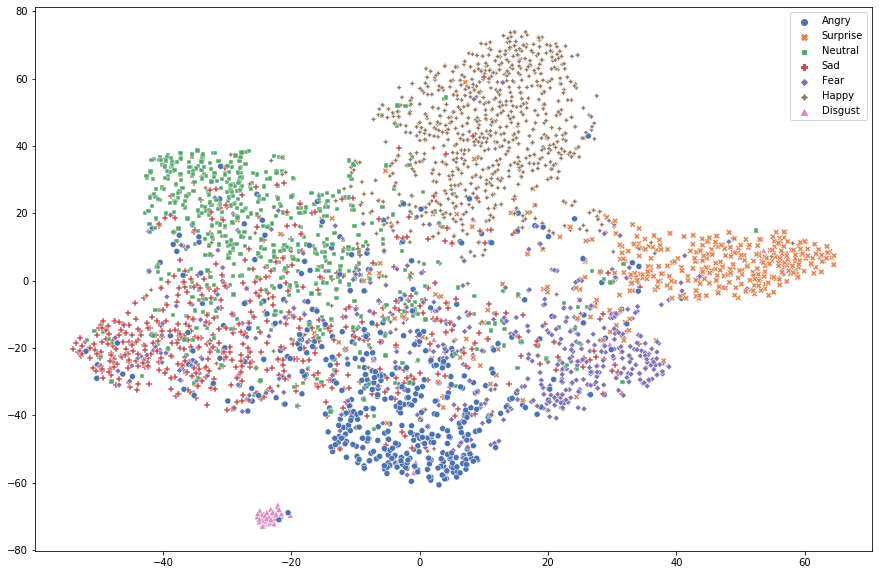

In [51]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], hue=str_labels, style=str_labels, palette="deep")


In [22]:
import pickle
pickle.dump(features, open('squeeze_excit_model/sqeeuze_excit_features.hdf5', 'wb'))

### SE + Multiatt

In [15]:
activation = {}
gradients = {}


device = torch.device('cpu')
model = torch.load('squeeze_excit_model/se_multiatt_model.pt')
# model = torch.load('multiatt/vanilla_singlealphas_varmultiatt_4_0041_pretrainedmodel.pt')
model = model.to(device)
model.eval()

model.att4.register_forward_hook(get_activation('last_conv'))
# model.att4.register_backward_hook(get_gradient('last_conv'))



In [16]:
test(model, val_loader,device=torch.device('cuda'))

- batch  0
- batch  1
- batch  2
- batch  3
- batch  4
- batch  5
- batch  6
- batch  7
- batch  8
- batch  9
- batch  10
- batch  11
- batch  12
- batch  13
- batch  14
- batch  15
- batch  16
- batch  17
- batch  18
- batch  19
- batch  20
- batch  21
- batch  22
- batch  23
- batch  24
- batch  25
- batch  26
- batch  27
- batch  28
- batch  29
- batch  30
- batch  31
- batch  32
- batch  33
- batch  34
- batch  35
- batch  36
- batch  37
- batch  38
- batch  39
- batch  40
- batch  41
- batch  42
- batch  43
- batch  44
- batch  45
- batch  46
- batch  47
- batch  48
- batch  49
- batch  50
- batch  51
- batch  52
- batch  53
- batch  54
- batch  55
- batch  56
- Avg. val_loss: 2.3540 | Avg. val_acc: 0.7010


(2.3539617676095865, 0.7010309278350515)

In [27]:
features = torch.cat(activation['last_conv'])
tsne_features, str_labels, _ = to_tsne(features, test_loader)

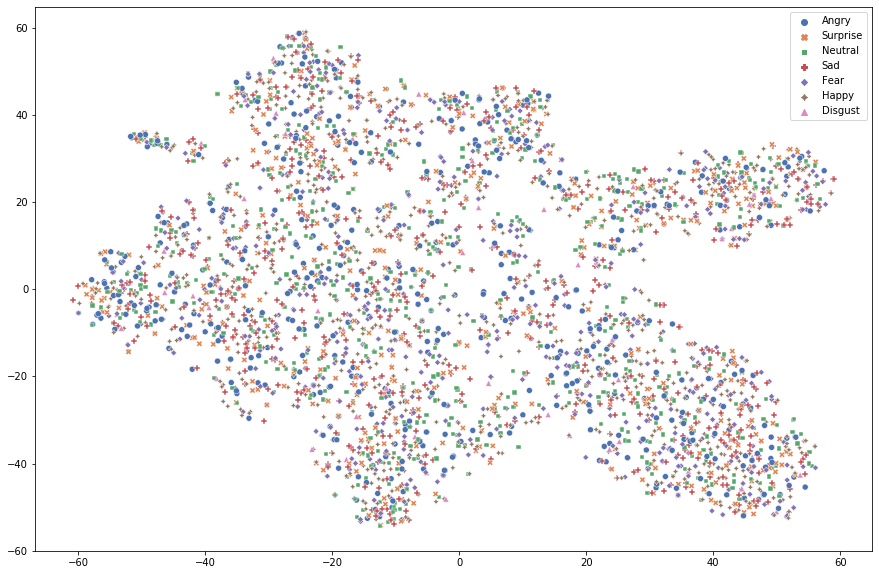

In [28]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], hue=str_labels, style=str_labels, palette="deep")


### Multiatt

In [14]:
activation = {}
gradients = {}


device = torch.device('cpu')
model = torch.load('multiatt/vanilla_alphas_multiatt_4_pretrainedmodel.pt')
model = model.to(device)
model.eval()

model.att4.register_forward_hook(get_activation('last_conv'))
# model.att4.register_backward_hook(get_gradient('last_conv'))



In [15]:
test(model, val_loader,device=torch.device('cuda'))

- batch  0


RuntimeError: shape '[-1, 256, 196]' is invalid for input of size 1048576

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 4, 4])
pooled grads:  torch.Size([1, 512, 1, 1])


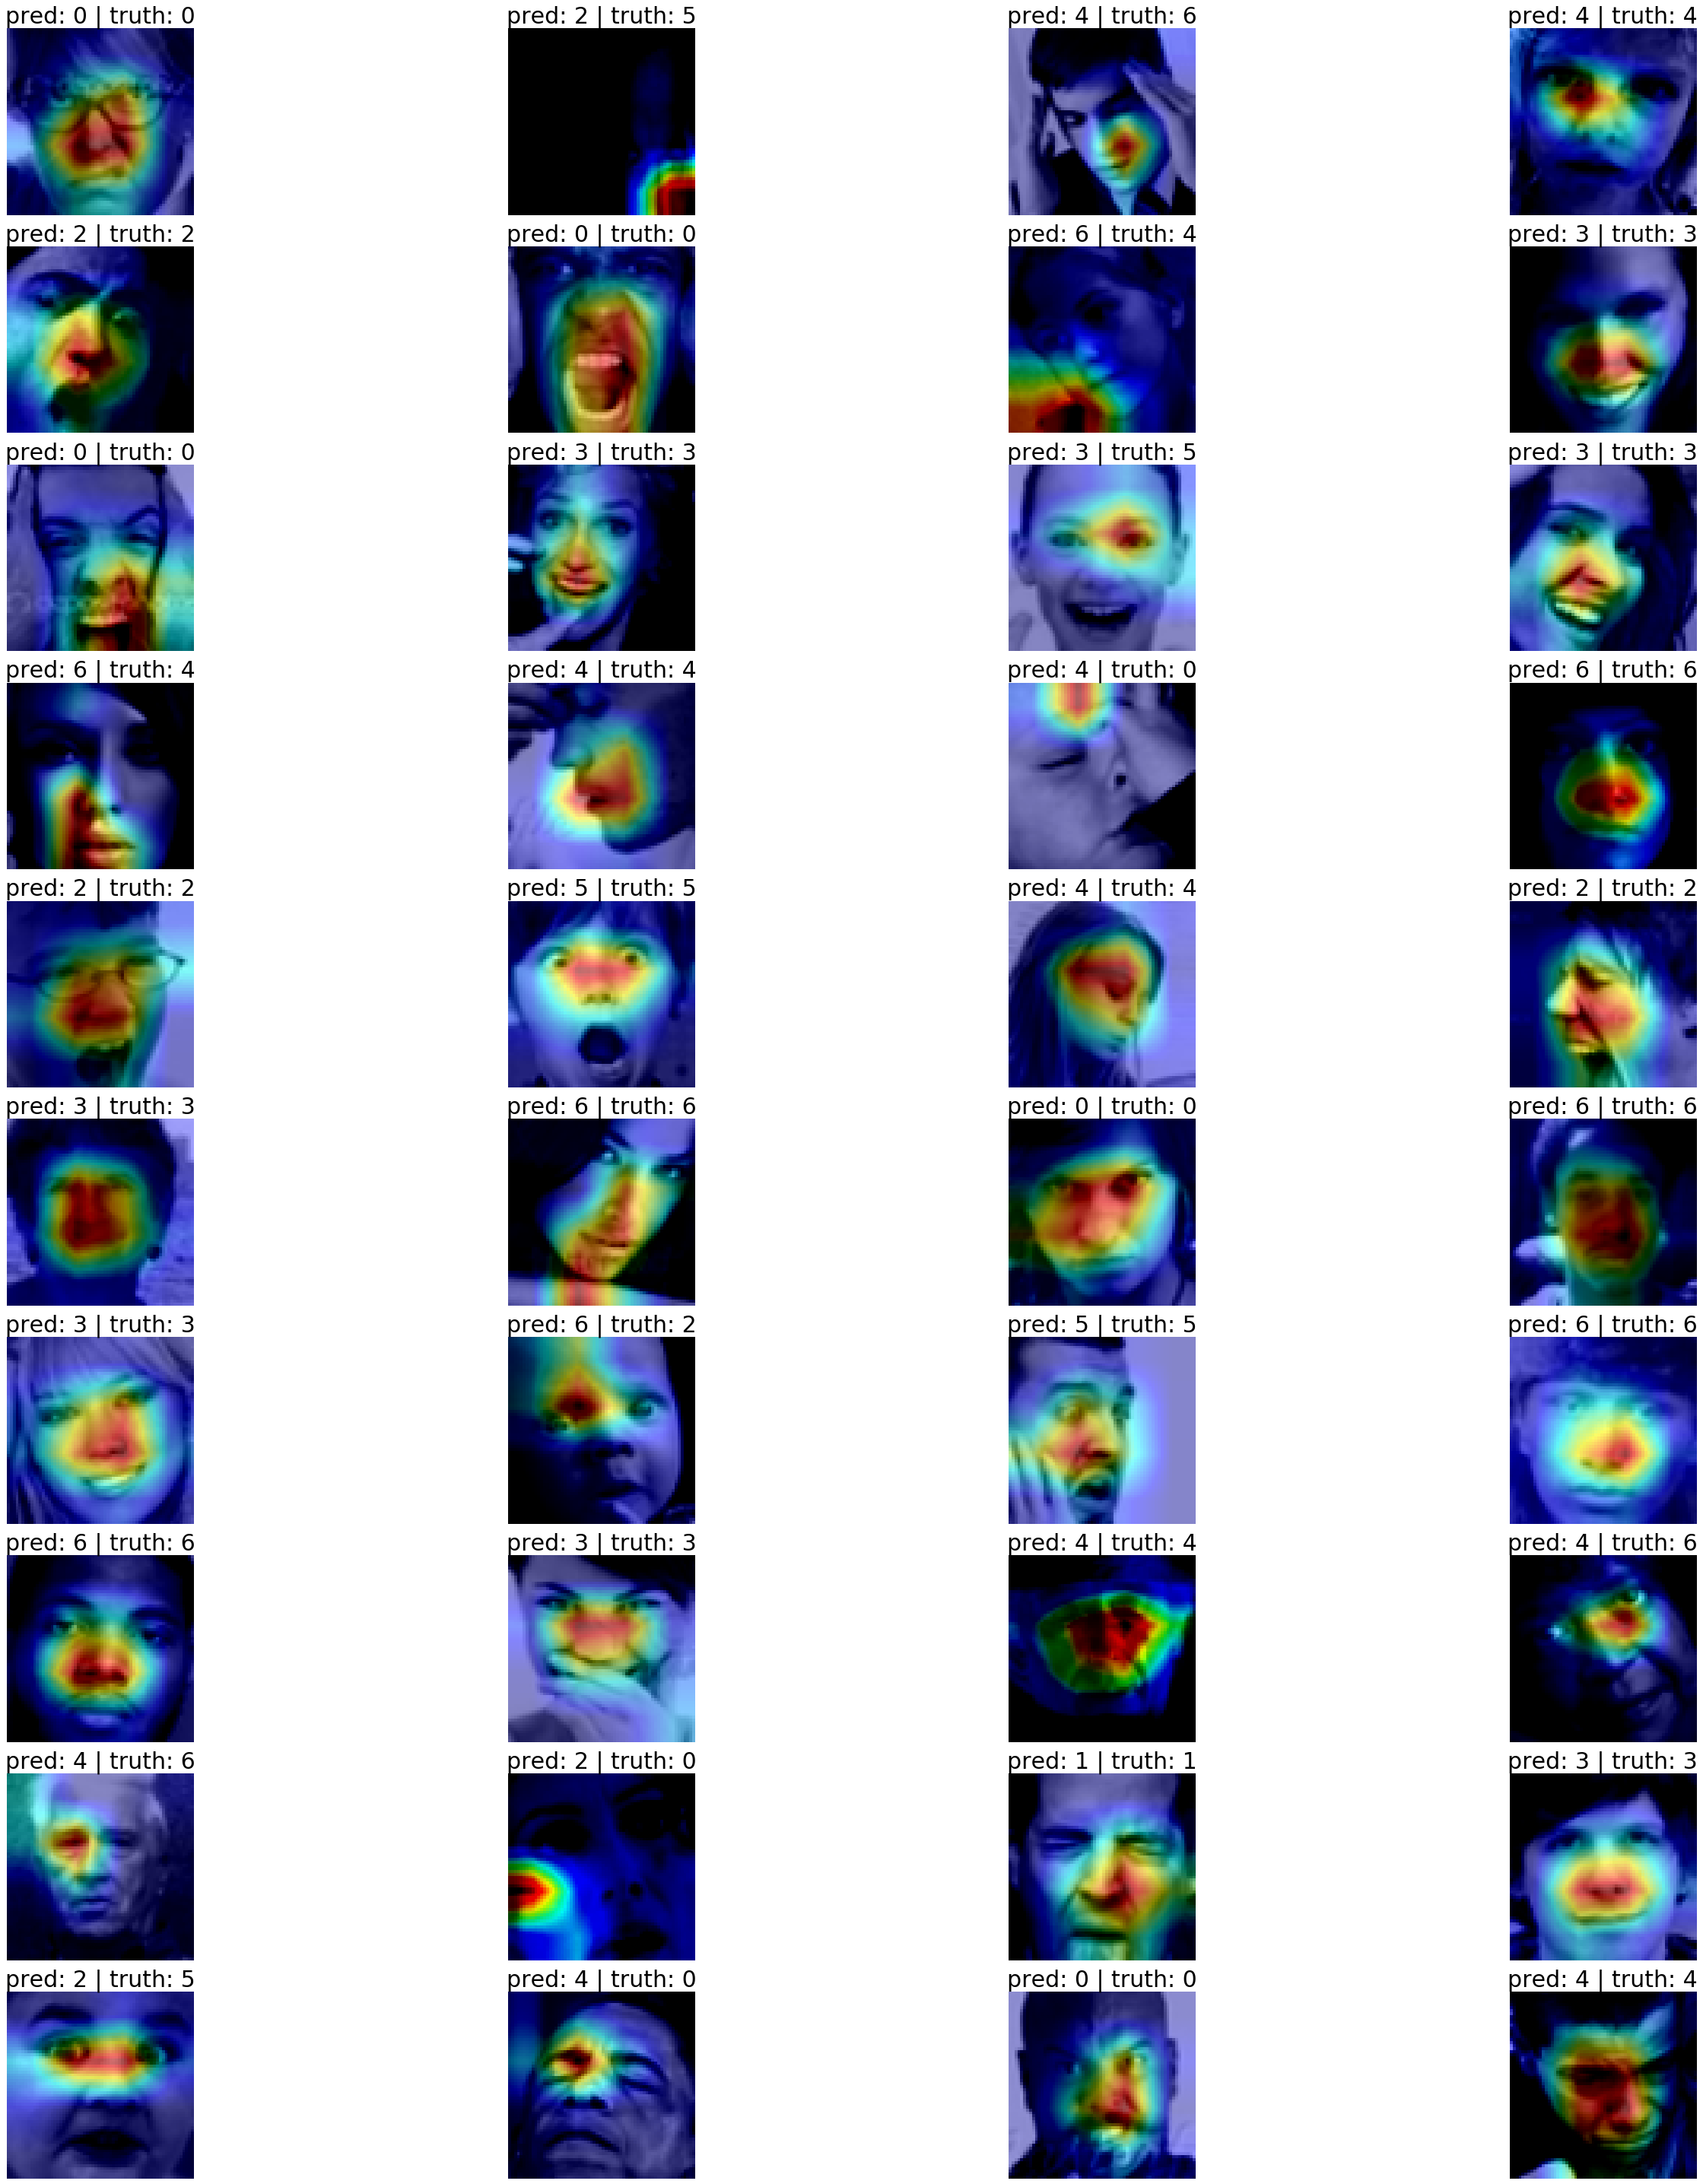

In [45]:
%matplotlib inline


#v1

images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id], ext_output=True)
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

### SE

In [51]:
%matplotlib inline

#v1

images, labels = next(next(iter(test_loader)))
images = images.to(device)
labels = labels.to(device)
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(model, images[id], labels[id], ext_output=True)
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

TypeError: 'list' object is not an iterator

## Compare history

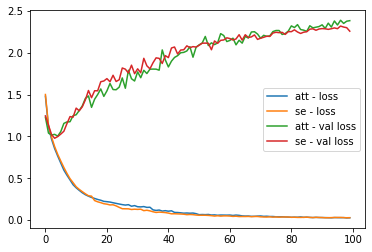

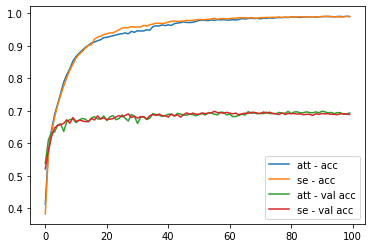

In [23]:
import pickle
import matplotlib.pyplot as plt
single_alpha = np.array(pickle.load(open('multiatt/vanilla_singlealphas_varmultiatt_4_0041_pretrainedhist.pt', 'rb')))
single_lambd = np.array(pickle.load(open('squeeze_excit_model/sqeeuze_excit_hist.hdf5', 'rb')))

plt.plot([k[0] for k in single_alpha], label='att - loss')
plt.plot([k[0] for k in single_lambd], label='se - loss')

plt.plot([k[1] for k in single_alpha], label='att - val loss')
plt.plot([k[1] for k in single_lambd], label='se - val loss')

plt.legend()
plt.show()

plt.plot([k[2] for k in single_alpha], label='att - acc')
plt.plot([k[2] for k in single_lambd], label='se - acc')

plt.plot([k[3] for k in single_alpha], label='att - val acc')
plt.plot([k[3] for k in single_lambd], label='se - val acc')

plt.legend()
plt.show()


### Conventional

In [24]:
import torch
from torch import nn

class Adjust(nn.Module):
    def __init__(self, depth):
        super(Adjust, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(depth))  # define the trainable parameter
        nn.init.constant_(self.weights.data, 1) 

    def forward(self, x):
        # assuming x is of size b-1-h-w
        return x * self.weights[None,:,None,None]  # element-wise multiplication

In [25]:
class Attention(nn.Module):
    def __init__(self, in_size):
        super(Attention, self).__init__()
        
        self.layernorm = nn.LayerNorm(in_size)
        self.act = nn.Sigmoid()
        self.adj = Adjust(in_size[0])
        
    def forward(self, x):
        
        x_norm = self.layernorm(x)
        x_norm = self.act(x_norm)
        x_norm = self.adj(x_norm)
        
        x_out = x * x_norm
        
        return x_out

In [26]:
class VGG_v1(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        super(VGG_v1, self).__init__()
        
        self.block1 = BasicBlock(in_channels, 32)
        self.block2 = BasicBlock(32, 64)
        self.block3 = BasicBlock(64, 128)
        self.block4 = BasicBlock(128, 256)
    
        self.att1 = Attention((32, 20, 20))
        self.att2 = Attention((64, 10, 10))
        self.att3 = Attention((128, 5, 5))
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
                              nn.Linear(256, 128, bias=True),
                              nn.BatchNorm1d(128),
                              nn.ReLU(inplace=True),
                              nn.Dropout(p=0.5, inplace=False),
                              
                              nn.Linear(128, 128, bias=True),
                              nn.BatchNorm1d(128),
                              nn.ReLU(inplace=True),
                              nn.Dropout(p=0.5, inplace=False),
        
                              nn.Linear(128, out_channels, bias=True))
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.att1(x)
        
        x = self.block2(x)
        x = self.maxpool(x)
        x = self.att2(x)
     
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.att3(x)
        
        x = self.block4(x)
        x = self.maxpool(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x

In [27]:
device = torch.device('cuda')
model = VGG_v1().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [28]:
model_path = 'model_v1.pt'

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.517477035522461 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:08<00:00, 25.48it/s]

- Avg.loss: 1.724 | Avg.acc: 0.305



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.525 | Avg. val_acc: 0.387
* Update optimal model
Epoch:  2


Loss=1.3447751998901367 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:08<00:00, 25.38it/s]

- Avg.loss: 1.404 | Avg.acc: 0.460



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.507 | Avg. val_acc: 0.391
* Update optimal model
Epoch:  3


Loss=1.3892560005187988 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:08<00:00, 25.35it/s]

- Avg.loss: 1.293 | Avg.acc: 0.511



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.321 | Avg. val_acc: 0.493
* Update optimal model
Epoch:  4


Loss=1.1181637048721313 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:08<00:00, 25.13it/s]

- Avg.loss: 1.225 | Avg.acc: 0.539



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.214 | Avg. val_acc: 0.527
* Update optimal model
Epoch:  5


Loss=1.0743685960769653 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:08<00:00, 25.33it/s]

- Avg.loss: 1.193 | Avg.acc: 0.555



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.547
* Update optimal model
Epoch:  6


Loss=1.269479513168335 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:08<00:00, 25.21it/s]

- Avg.loss: 1.149 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157 | Avg. val_acc: 0.555
* Update optimal model
Epoch:  7


Loss=0.8810433149337769 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:08<00:00, 25.14it/s]

- Avg.loss: 1.127 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.588
* Update optimal model
Epoch:  8


Loss=1.0389137268066406 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:08<00:00, 25.23it/s]

- Avg.loss: 1.108 | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.111 | Avg. val_acc: 0.578
Epoch:  9


Loss=1.0231585502624512 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:08<00:00, 25.43it/s]

- Avg.loss: 1.078 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117 | Avg. val_acc: 0.583
Epoch:  10


Loss=1.1484194993972778 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:09<00:00, 24.41it/s]

- Avg.loss: 1.059 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.594
* Update optimal model
Epoch:  11


Loss=0.9586671590805054 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:08<00:00, 25.15it/s]

- Avg.loss: 1.049 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.595
* Update optimal model
Epoch:  12


Loss=1.478414535522461 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:08<00:00, 25.27it/s]

- Avg.loss: 1.028 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.609
* Update optimal model
Epoch:  13


Loss=1.1168630123138428 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:09<00:00, 24.68it/s]

- Avg.loss: 1.012 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.119 | Avg. val_acc: 0.579
Epoch:  14


Loss=1.1115303039550781 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:09<00:00, 24.95it/s]

- Avg.loss: 0.998 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.111 | Avg. val_acc: 0.596
Epoch:  15


Loss=0.9316739439964294 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:08<00:00, 25.39it/s]

- Avg.loss: 0.996 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061 | Avg. val_acc: 0.603
Epoch:  16


Loss=0.8179858326911926 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:08<00:00, 25.05it/s]

- Avg.loss: 0.966 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077 | Avg. val_acc: 0.604
Epoch:  17


Loss=0.8414720892906189 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:09<00:00, 24.90it/s]

- Avg.loss: 0.960 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.596
Epoch:  18


Loss=0.9836875200271606 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:08<00:00, 25.25it/s]

- Avg.loss: 0.948 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046 | Avg. val_acc: 0.614
* Update optimal model
Epoch:  19


Loss=0.9343178272247314 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:09<00:00, 24.97it/s]

- Avg.loss: 0.937 | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.065 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  20


Loss=0.9486883282661438 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:08<00:00, 25.12it/s]

- Avg.loss: 0.923 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.104 | Avg. val_acc: 0.608
Epoch:  21


Loss=0.9010128378868103 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:08<00:00, 25.36it/s]

- Avg.loss: 0.907 | Avg.acc: 0.674



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050 | Avg. val_acc: 0.619
* Update optimal model
Epoch:  22


Loss=0.8298929333686829 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:09<00:00, 24.94it/s]

- Avg.loss: 0.900 | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172 | Avg. val_acc: 0.591
Epoch:  23


  0%|          | 0/225 [00:00<?, ?it/s]uracy=0.6484375:  76%|███████▌  | 171/225 [00:06<00:01, 27.33it/s] 

- Avg. val_loss: 1.072 | Avg. val_acc: 0.639
* Update optimal model
Epoch:  33


Loss=1.0235857963562012 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:08<00:00, 25.33it/s]

- Avg.loss: 0.741 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.622
Epoch:  34


Loss=0.7593351006507874 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:09<00:00, 24.88it/s]


- Avg.loss: 0.725 | Avg.acc: 0.743


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.631
Epoch:  35


Loss=0.7806879878044128 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:08<00:00, 25.05it/s]

- Avg.loss: 0.713 | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.643
* Update optimal model
Epoch:  36


Loss=0.5305384993553162 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:08<00:00, 25.18it/s]

- Avg.loss: 0.712 | Avg.acc: 0.749



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.107 | Avg. val_acc: 0.631
Epoch:  37


Loss=0.6654588580131531 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 25.32it/s]

- Avg.loss: 0.701 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.632
Epoch:  38


Loss=0.6797677874565125 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 25.44it/s]

- Avg.loss: 0.694 | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.627
Epoch:  39


Loss=0.9656951427459717 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:09<00:00, 24.61it/s]

- Avg.loss: 0.680 | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.642
Epoch:  40


Loss=0.7265246510505676 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:09<00:00, 24.76it/s]

- Avg.loss: 0.673 | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116 | Avg. val_acc: 0.631
Epoch:  41


Loss=0.626307487487793 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 25.51it/s]

- Avg.loss: 0.661 | Avg.acc: 0.767



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157 | Avg. val_acc: 0.635
Epoch    41: reducing learning rate of group 0 to 5.6250e-04.
Epoch:  42


Loss=0.540259063243866 Batch_id=187 Accuracy=0.8046875:  84%|████████▎ | 188/225 [00:07<00:01, 27.06it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.5778791308403015 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 25.19it/s]

- Avg.loss: 0.448 | Avg.acc: 0.846



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.412 | Avg. val_acc: 0.648
Epoch:  65


Loss=0.7011265754699707 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 25.22it/s]

- Avg.loss: 0.440 | Avg.acc: 0.852



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.335 | Avg. val_acc: 0.651
Epoch:  66


Loss=0.29179736971855164 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:09<00:00, 24.81it/s]

- Avg.loss: 0.440 | Avg.acc: 0.850



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.350 | Avg. val_acc: 0.652
Epoch    66: reducing learning rate of group 0 to 3.1641e-04.
Epoch:  67


Loss=0.43470799922943115 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:09<00:00, 24.73it/s]

- Avg.loss: 0.413 | Avg.acc: 0.856



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.334 | Avg. val_acc: 0.649
Epoch:  68


Loss=0.3374064862728119 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:08<00:00, 25.12it/s]

- Avg.loss: 0.409 | Avg.acc: 0.862



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.312 | Avg. val_acc: 0.656
* Update optimal model
Epoch:  69


Loss=0.2344401776790619 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:08<00:00, 25.02it/s]

- Avg.loss: 0.394 | Avg.acc: 0.864



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.391 | Avg. val_acc: 0.654
Epoch:  70


Loss=0.6349888443946838 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 25.26it/s]

- Avg.loss: 0.391 | Avg.acc: 0.866



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.414 | Avg. val_acc: 0.658
* Update optimal model
Epoch:  71


Loss=0.39394864439964294 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:08<00:00, 25.18it/s]

- Avg.loss: 0.393 | Avg.acc: 0.869



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.345 | Avg. val_acc: 0.652
Epoch:  72


Loss=0.4273315668106079 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:09<00:00, 24.98it/s]

- Avg.loss: 0.390 | Avg.acc: 0.869



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.415 | Avg. val_acc: 0.651
Epoch:  73


Loss=0.6278257369995117 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 25.00it/s]

- Avg.loss: 0.388 | Avg.acc: 0.869



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.388 | Avg. val_acc: 0.656
Epoch:  74


Loss=0.38005098700523376 Batch_id=25 Accuracy=0.8671875:  12%|█▏        | 26/225 [00:01<00:11, 17.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.6051366925239563 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:09<00:00, 24.58it/s]

- Avg.loss: 0.325 | Avg.acc: 0.890



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.522 | Avg. val_acc: 0.657
Epoch:  88


Loss=0.3322261571884155 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:08<00:00, 25.04it/s]

- Avg.loss: 0.319 | Avg.acc: 0.892



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.494 | Avg. val_acc: 0.660
Epoch    88: reducing learning rate of group 0 to 1.7798e-04.
Epoch:  89


Loss=0.3007504642009735 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:08<00:00, 25.02it/s]

- Avg.loss: 0.307 | Avg.acc: 0.897



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.541 | Avg. val_acc: 0.660
Epoch:  90


Loss=0.6157675385475159 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 25.11it/s]

- Avg.loss: 0.304 | Avg.acc: 0.899



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.523 | Avg. val_acc: 0.662
Epoch:  91


Loss=0.1961747705936432 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:08<00:00, 25.31it/s]

- Avg.loss: 0.302 | Avg.acc: 0.900



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.513 | Avg. val_acc: 0.656
Epoch:  92


Loss=0.34200212359428406 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:08<00:00, 25.32it/s]

- Avg.loss: 0.304 | Avg.acc: 0.899



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.516 | Avg. val_acc: 0.656
Epoch:  93


Loss=0.11492808163166046 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:08<00:00, 25.37it/s]

- Avg.loss: 0.305 | Avg.acc: 0.897



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.528 | Avg. val_acc: 0.661
Epoch:  94


Loss=0.19238388538360596 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:08<00:00, 25.35it/s]

- Avg.loss: 0.295 | Avg.acc: 0.903



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.550 | Avg. val_acc: 0.656
Epoch    94: reducing learning rate of group 0 to 1.3348e-04.
Epoch:  95


Loss=0.31440240144729614 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:09<00:00, 24.85it/s]

- Avg.loss: 0.281 | Avg.acc: 0.904



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.520 | Avg. val_acc: 0.661
Epoch:  96


Loss=0.3265611529350281 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:08<00:00, 25.01it/s]

- Avg.loss: 0.283 | Avg.acc: 0.904



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.562 | Avg. val_acc: 0.657
Epoch:  97


Loss=0.6332899928092957 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 25.17it/s]

- Avg.loss: 0.290 | Avg.acc: 0.902



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.570 | Avg. val_acc: 0.663
Epoch:  98


Loss=0.35498249530792236 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:08<00:00, 25.43it/s]

- Avg.loss: 0.282 | Avg.acc: 0.905



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.551 | Avg. val_acc: 0.660
Epoch:  99


Loss=0.13981834053993225 Batch_id=224 Accuracy=0.972972972972973: 100%|██████████| 225/225 [00:08<00:00, 25.22it/s]

- Avg.loss: 0.279 | Avg.acc: 0.906



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.611 | Avg. val_acc: 0.652
Epoch:  100


Loss=0.14437754452228546 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:08<00:00, 25.16it/s]

- Avg.loss: 0.268 | Avg.acc: 0.910


- Avg. val_loss: 1.605 | Avg. val_acc: 0.659
Epoch   100: reducing learning rate of group 0 to 1.0011e-04.
Finished Training


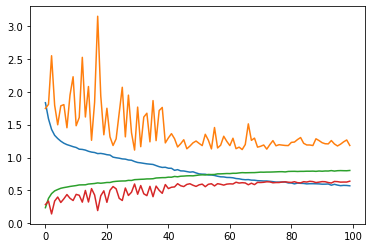

In [10]:
#4block kl
plt.plot(hist)

([<matplotlib.lines.Line2D at 0x7fbd8c38a4e0>,
 0.6673168013374199)

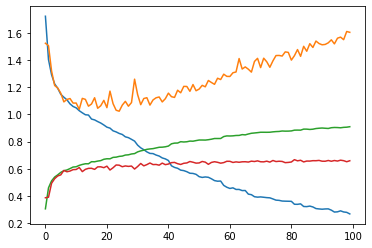

In [31]:
#4block kl

plt.plot(hist), best_acc

### Center loss

In [26]:
x = torch.rand(12, 64)
centers = nn.Parameter(torch.randn(7, 64))

In [40]:
import torch
import torch.nn as nn

batch_size=12
num_classes=7



distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, num_classes) + \
                  torch.pow(centers, 2).sum(dim=1, keepdim=True).expand(num_classes, batch_size).t()

In [35]:
distmat.size()

torch.Size([12, 7])

In [39]:
c = distmat.addmm_(1, -2, x, centers.t())

In [41]:
(distmat - 2*(torch.matmul(x, centers.t()))) - c

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)